In [65]:
import os
import sys
import pickle
import warnings
import time
import logging
import glob


import numpy as np
from sklearn.neighbors import KDTree
import matplotlib.pyplot as plt
from iminuit import Minuit


from utils import *


import seaborn as sns
from matplotlib import rcParams
from cycler import cycler


## Set plotting style and print options
sns.set_theme()
sns.set_style("darkgrid")
sns.set_context("paper") #Possible are paper, notebook, talk and poster

d = {'lines.linewidth': 2, 'axes.titlesize': 20, 'axes.titleweight': 'bold', 'axes.labelsize': 18, 'xtick.labelsize': 12, 'axes.labelweight': 'bold', 'ytick.labelsize': 12,\
     'legend.fontsize': 15, 'font.family': 'serif', 'font.weight': 'bold', 'figure.titlesize': 20,'figure.titleweight': 'bold',\
          'figure.labelsize': 18,'figure.labelweight': 'bold', 'figure.figsize': (9,6), }
d_colors = {'axes.prop_cycle': cycler(color = ['teal', 'navy', 'coral', 'plum', 'purple', 'olivedrab',\
         'black', 'red', 'cyan', 'brown', 'green', 'yellow', 'khaki','lightblue'])}
rcParams.update(d)
rcParams.update(d_colors)
np.set_printoptions(precision = 5, suppress=1e-10)

In [66]:
output_path = 'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis512_LL0.05'
output_path_long = output_path + '_very_long'
save_path = 'data\\nematic_analysis512_LL0.05'

if not os.path.exists(save_path):
    os.makedirs(save_path)
path0 = os.path.join(output_path, 'analysis_zeta_0.022\\zeta_0.022_counter_0')
path0_long = os.path.join(output_path_long, 'analysis_zeta_0.020\\zeta_0.020_counter_0')
sys.path.append(output_path)

Nexp = 10
Nexp_long = 20
Nframes = 181
Nframes = len(np.loadtxt(os.path.join(path0, 'Ndefects_act0.022_exp0.txt')))
Nframes_long = len(np.loadtxt(os.path.join(path0_long, 'Ndefects_act0.02_exp0.txt')))
LX = 512

act_list = []
act_dir_list = []
act_list_long = []
act_dir_list_long = []

for file in os.listdir(output_path):
        activity = file.split('_')[-1]
        act_list.append(float(activity))
        act_dir_list.append(os.path.join(output_path, file))
for file in os.listdir(output_path_long):
        activity = file.split('_')[-1]
        act_list_long.append(float(activity))
        act_dir_list_long.append(os.path.join(output_path_long, file))

# sort the activity list and the activity directory list
act_list, act_dir_list = zip(*sorted(zip(act_list, act_dir_list)))
act_list_long, act_dir_list_long = zip(*sorted(zip(act_list_long, act_dir_list_long)))

Nactivity = len(act_list)
Nactivity_long = len(act_list_long)
conv_list = Nactivity * [0]

# save act list
np.savetxt(os.path.join(save_path, 'act_list.txt'), act_list)

Nexp, Nexp_long, Nframes, Nframes_long, Nactivity


(10, 20, 181, 1501, 37)

In [5]:
act_list_long

(0.0195, 0.02, 0.0205, 0.021, 0.0215, 0.022, 0.0225)

In [67]:

conv_dict = dict(zip(act_list, conv_list))

window_sizes = np.loadtxt(os.path.join(path0, 'window_sizes.txt'))

defect_arr = np.nan * np.zeros((Nframes, Nactivity, Nexp))
av_counts = np.nan * np.zeros([Nframes, len(window_sizes), Nactivity, Nexp])
var_counts = np.nan * np.zeros([Nframes, len(window_sizes), Nactivity, Nexp])
count_lengths = np.zeros([Nactivity, Nexp])

defect_arr_long = np.nan * np.zeros((Nframes_long, Nactivity_long, Nexp_long))
av_counts_long = np.nan * np.zeros([Nframes_long, len(window_sizes), Nactivity_long, Nexp_long])
var_counts_long = np.nan * np.zeros([Nframes_long, len(window_sizes), Nactivity_long, Nexp_long])
count_lengths_long = np.zeros([Nactivity_long, Nexp_long])

for i, act in enumerate(act_list_long):
        
        exp_list = []
        exp_dir_list = []

        for file in os.listdir(act_dir_list_long[i]):
                exp_count = file.split('_')[-1]
                exp_list.append(int(exp_count))
                exp_dir_list.append(os.path.join(act_dir_list_long[i], file))

        # sort the activity list and the activity directory list
        exp_list, exp_dir_list = zip(*sorted(zip(exp_list, exp_dir_list)))

        for exp, exp_dir in zip(exp_list, exp_dir_list):
                defect_arr_long[:, i, exp] = np.loadtxt(os.path.join(exp_dir, 'Ndefects_act{}_exp{}.txt'.format(act, exp)))[:Nframes_long]

                counts = np.loadtxt(os.path.join(exp_dir, 'av_counts_act{}_exp{}.txt'.format(act,exp)))[:Nframes_long,:]
                vars = np.loadtxt(os.path.join(exp_dir, 'count_fluctuations_act{}_exp{}.txt'.format(act,exp)))[:Nframes_long,:]

                idx_start_count = min(Nframes_long - conv_list[i], len(counts))
                av_counts_long[-idx_start_count:, :, i, exp] = counts[-idx_start_count:, :]
                var_counts_long[-idx_start_count:, :, i, exp] = vars[-idx_start_count:, :]
                count_lengths_long[i, exp] = idx_start_count
                


for i, act in enumerate(act_list):
    
    exp_list = []
    exp_dir_list = []

    for file in os.listdir(act_dir_list[i]):
            exp_count = file.split('_')[-1]
            exp_list.append(int(exp_count))
            exp_dir_list.append(os.path.join(act_dir_list[i], file))

    # sort the activity list and the activity directory list
    exp_list, exp_dir_list = zip(*sorted(zip(exp_list, exp_dir_list)))

    for exp, exp_dir in zip(exp_list, exp_dir_list):
        defect_arr[:, i, exp] = np.loadtxt(os.path.join(exp_dir, 'Ndefects_act{}_exp{}.txt'.format(act, exp)))[:Nframes]


        counts = np.loadtxt(os.path.join(exp_dir, 'av_counts_act{}_exp{}.txt'.format(act,exp)))[:Nframes,:]
        vars = np.loadtxt(os.path.join(exp_dir, 'count_fluctuations_act{}_exp{}.txt'.format(act,exp)))[:Nframes,:]

        idx_start_count = min(Nframes - conv_list[i], len(counts))
        av_counts[-idx_start_count:, :, i, exp] = counts[-idx_start_count:, :]
        var_counts[-idx_start_count:, :, i, exp] = vars[-idx_start_count:, :]
        count_lengths[i, exp] = idx_start_count

dens_fluc = var_counts / (np.pi * window_sizes[:, None, None] ** 2) ** 2
dens_fluc_long = var_counts_long / (np.pi * window_sizes[:, None, None] ** 2) ** 2

np.save(os.path.join(save_path, 'defect_arr.npy'), defect_arr)
np.save(os.path.join(save_path, 'av_counts.npy'), av_counts)
np.save(os.path.join(save_path, 'var_counts.npy'), var_counts)
np.save(os.path.join(save_path, 'dens_fluc.npy'), dens_fluc)

np.save(os.path.join(save_path, 'defect_arr_very_long.npy'), defect_arr_long)
np.save(os.path.join(save_path, 'av_counts_very_long.npy'), av_counts_long)
np.save(os.path.join(save_path, 'var_counts_very_long.npy'), var_counts_long)
np.save(os.path.join(save_path, 'dens_fluc_very_long.npy'), dens_fluc_long)

In [83]:
Nframes = 300
defect_arr_long = defect_arr_long[-Nframes:, :, :]
Nframes_long = defect_arr_long.shape[0]
var_counts_long = var_counts_long[-Nframes:,]   
dens_fluc_long = var_counts_long / (np.pi * window_sizes[:, None, None] ** 2) ** 2

defect_arr_av_long = np.nanmean(defect_arr_long, axis = 2)
defect_arr_std_long = np.nanstd(defect_arr_long, axis = 2)

# save defect_arr_av_long and defect_arr_std_long
np.save(os.path.join(save_path, 'defect_arr_av_very_long.npy'), defect_arr_av_long)
np.save(os.path.join(save_path, 'defect_arr_std_very_long.npy'), defect_arr_std_long)

av_dens_arr = defect_arr_long / (LX ** 2)
dens_fluc_full = dens_fluc_long / av_dens_arr[:, None, :, :] ** 2
dens_fluc_full_av = np.nanmean(dens_fluc_full, axis = 3)
dens_fluc_full_std = np.nanstd(dens_fluc_full, axis = 3) / np.sqrt((~np.isnan(defect_arr_long[0,:,:])).sum(axis=-1))[None, None, :,]
xi_av_full = np.nanmean(dens_fluc_full_av, axis = 0)
xi_std_full = np.nanstd(dens_fluc_full_av, axis = 0) / np.sqrt(Nframes_long)

# save xi
np.savetxt(os.path.join(save_path, 'xi_av_full_very_long.txt'), xi_av_full)
np.savetxt(os.path.join(save_path, 'xi_std_full_very_long.txt'), xi_std_full)
# save dens_fluc_full av and std
np.save(os.path.join(save_path, 'dens_fluc_full_av_very_long.npy'), dens_fluc_full_av)
np.save(os.path.join(save_path, 'dens_fluc_full_std_very_long.npy'), dens_fluc_full_std)

var_counts_long_av = np.nanmean(var_counts_long, axis = 3)
var_counts_long_std = np.nanstd(var_counts_long, axis = 3) / np.sqrt((~np.isnan(defect_arr_long[0,:,:])).sum(axis=-1))[None, None, :,]

# save var_counts_long av and std
np.save(os.path.join(save_path, 'var_counts_long_av_very_long.npy'), var_counts_long_av)
np.save(os.path.join(save_path, 'var_counts_long_std_very_long.npy'), var_counts_long_std)

C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_8684\4053926635.py:16: RuntimeWarning: Mean of empty slice
  dens_fluc_full_av = np.nanmean(dens_fluc_full, axis = 3)
c:\Users\Simon Andersen\miniconda3\envs\sf\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_8684\4053926635.py:28: RuntimeWarning: Mean of empty slice
  var_counts_long_av = np.nanmean(var_counts_long, axis = 3)


In [82]:
av_defects = np.zeros((Nactivity_long, 2)) 

for i, act in enumerate(act_list_long):
    av_defects[i, 0] = np.mean(defect_arr_av_long[:,i])
    av_defects[i, 1] = np.mean(defect_arr_std_long[:,i]) / np.sqrt(Nframes_long)

# save av_defects
np.savetxt(os.path.join(save_path, 'av_defects_very_long.txt'), av_defects)


In [81]:
defect_arr_av_long.shape

(300, 7)

In [35]:
min_window_idx=0
first_frame_list = np.array(conv_list)
Nframes_non_nan_counts = Nframes - np.array(first_frame_list)
min_act_idx = 0

In [23]:
# save exp_conv_list_long
np.savetxt(os.path.join(save_path, 'exp_conv_list_long.txt'), exp_conv_list_long)

In [19]:
exp_conv_list_long = np.ones((Nexp_long, Nactivity_long)).astype(float)
mask = (np.mean(defect_arr_long, axis = 0) == 0).T
exp_conv_list_long[mask] = np.nan

mask_conv = exp_conv_list_long == -1
mask_no_prof = exp_conv_list_long == 0
mask_low_prof = exp_conv_list_long == 2

defect_arr_long_non_zero = defect_arr_long * exp_conv_list_long.T[np.newaxis, :, :]

defect_arr_av_long = np.nanmean(defect_arr_long_non_zero, axis = 2)
defect_arr_std_long = np.nanstd(defect_arr_long_non_zero, axis = 2)

In [69]:
defect_arr_av_long = np.nanmean(defect_arr_long, axis = 2)
defect_arr_std_long = np.nanstd(defect_arr_long, axis = 2)

In [63]:
defect_arr_av_long.shape

(300, 7)

In [21]:
mask_zero = (np.mean(defect_arr_long, axis = 0) == 0)
mask_conv = exp_conv_list_long == -1
mask_no_prof = exp_conv_list_long == 0
mask_low_prof = exp_conv_list_long == 2
mask_conv.shape

(20, 7)

In [22]:
#defect_arr_long_non_zero[:, mask_conv.T] = np.nan
defect_arr_long_non_zero = defect_arr_long.astype(float) 
defect_arr_long_non_zero[:, mask_zero] = np.nan

defect_arr_long_non_zero[:, mask_no_prof.T] = np.nan
defect_arr_long_non_zero[:, mask_conv.T] = np.nan

defect_arr_av_long = np.nanmean(defect_arr_long_non_zero, axis = 2)
defect_arr_std_long = np.nanstd(defect_arr_long_non_zero, axis = 2)

defect_arr_long_non_zero[:, mask_no_prof.T] = np.nan
defect_arr_long_non_zero[:, mask_conv.T] = np.nan

defect_arr_high = defect_arr_long_non_zero.astype(float)
defect_arr_high[:, mask_low_prof.T] = np.nan

defect_arr_mid = defect_arr_long_non_zero.astype(float)
defect_arr_mid[:, ~mask_low_prof.T] = np.nan

defect_arr_high_av = np.nanmean(defect_arr_high, axis = 2)
defect_arr_mid_av = np.nanmean(defect_arr_mid, axis = 2)

defect_arr_high_std = np.nanstd(defect_arr_high, axis = 2)
defect_arr_mid_std = np.nanstd(defect_arr_mid, axis = 2)



C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_8684\2374286468.py:21: RuntimeWarning: Mean of empty slice
  defect_arr_mid_av = np.nanmean(defect_arr_mid, axis = 2)
c:\Users\Simon Andersen\miniconda3\envs\sf\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

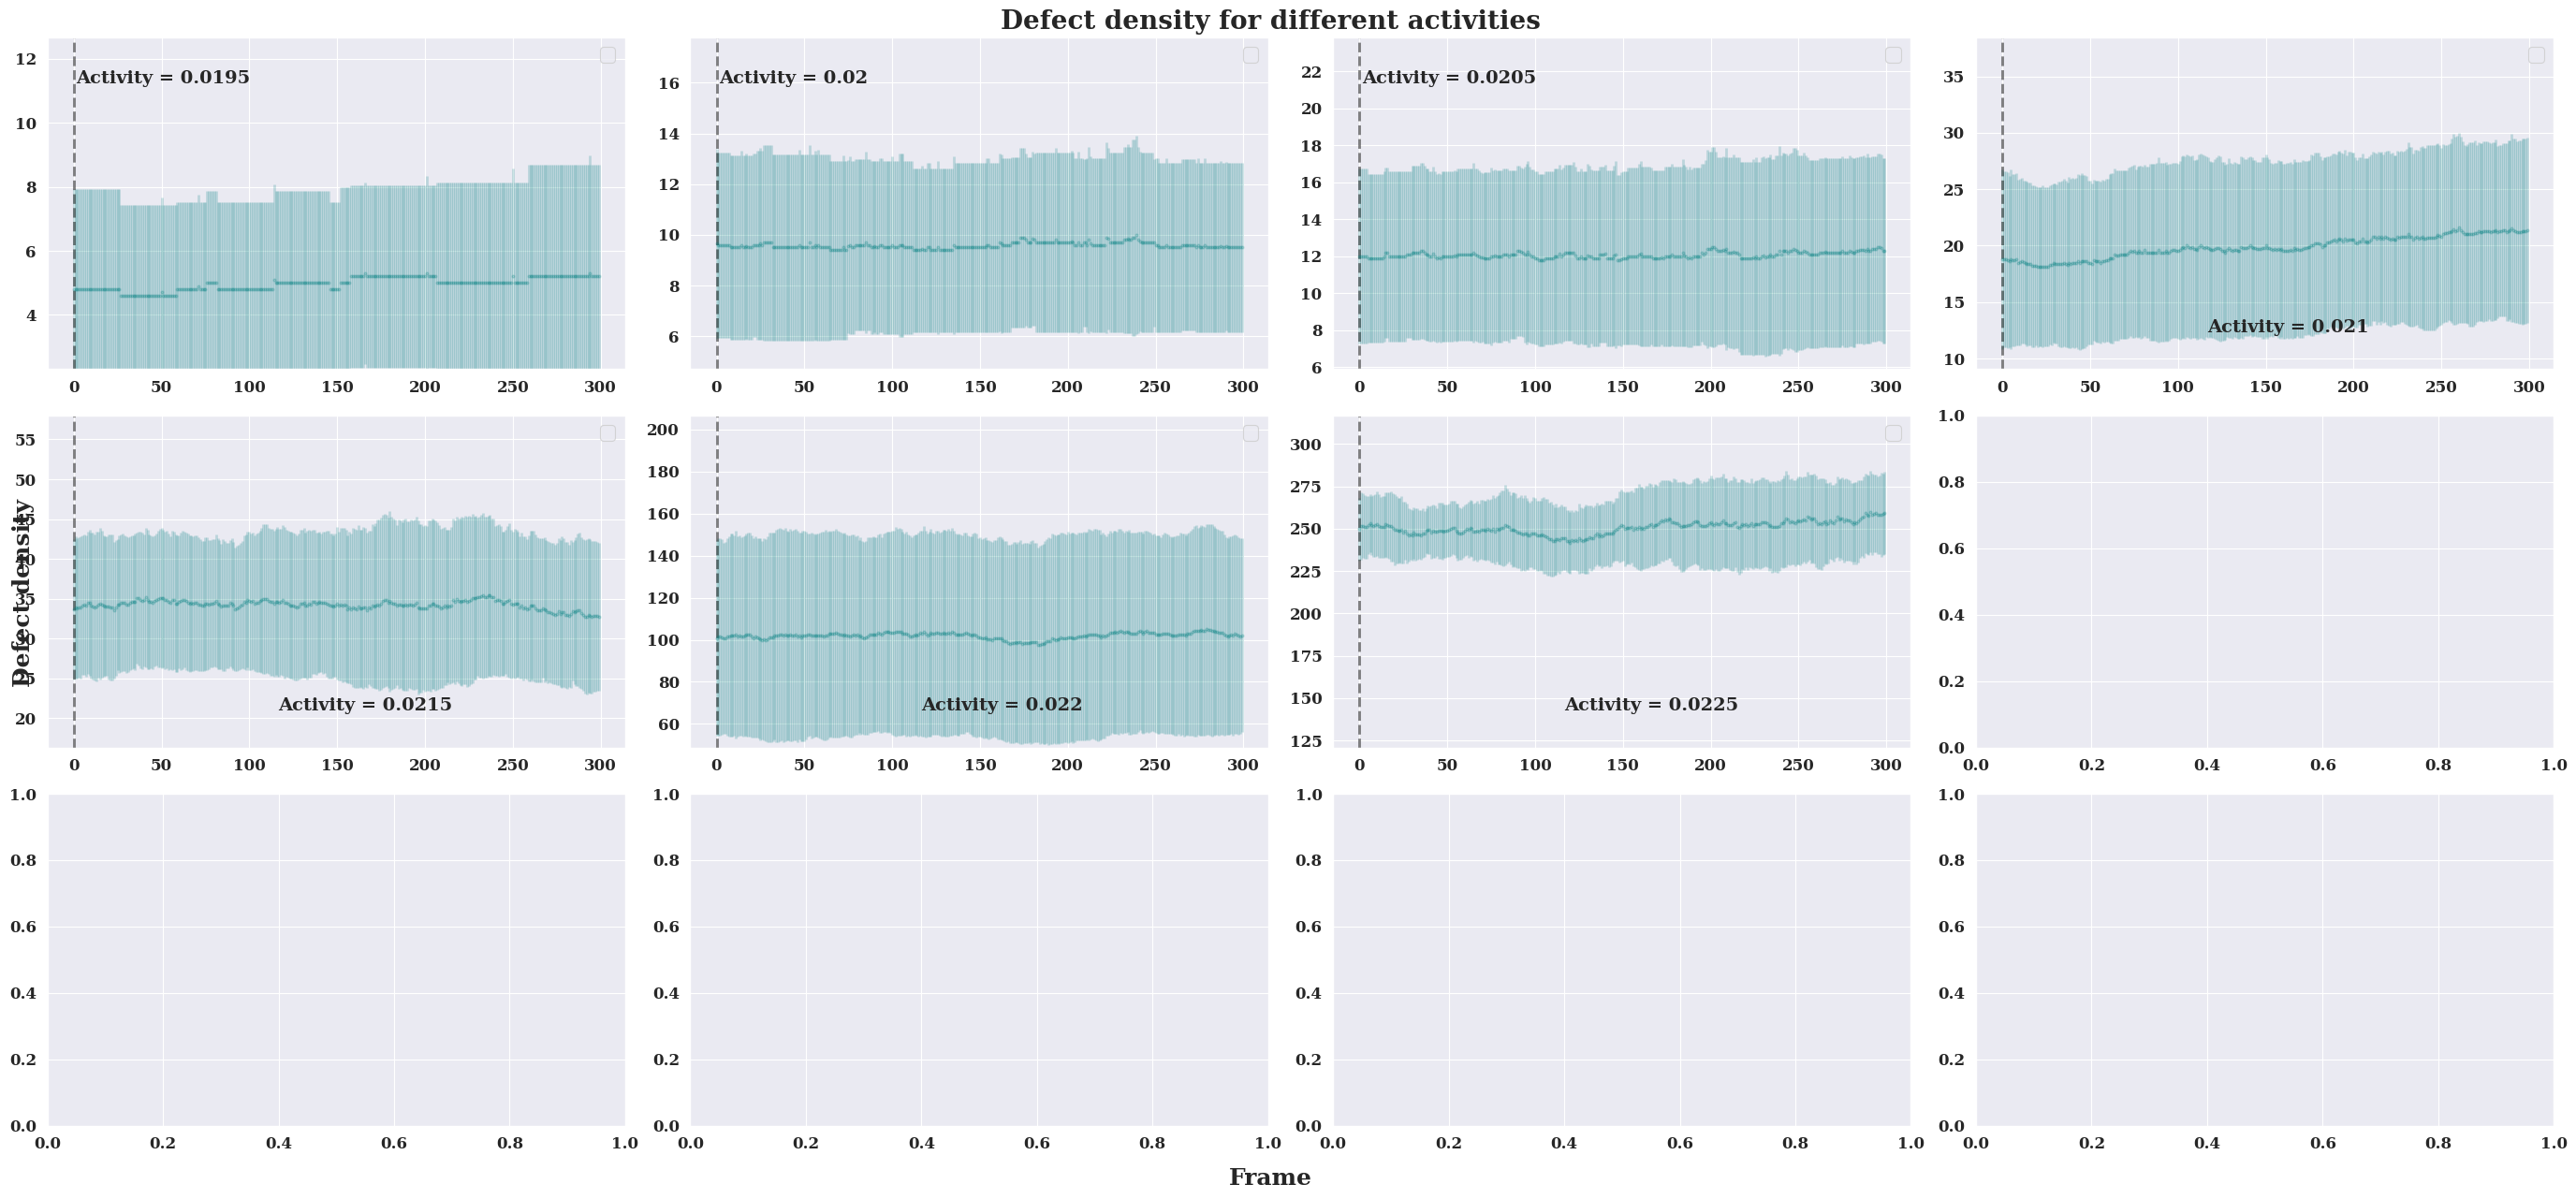

In [75]:
ncols = 4
nrows = int(np.ceil(Nactivity_long / ncols))
nrows = 3
fig, ax = plt.subplots(nrows = nrows, ncols = 4, figsize=(28, 13))
ax = ax.flatten()
for i, act in enumerate(act_list_long):
    act_idx = act_list_long.index(act)
    ax[i].errorbar(np.arange(Nframes_long), defect_arr_av_long[:, act_idx], defect_arr_std_long[:, act_idx], fmt='.', \
                    alpha = 0.2, markersize=4,)
   # ax[i].errorbar(np.arange(Nframes_long), defect_arr_high_av[:, act_idx], defect_arr_high_std[:, act_idx], label='high', fmt='.', \
   #                 alpha = 0.2, markersize=4,)
   # ax[i].errorbar(np.arange(Nframes_long), defect_arr_mid_av[:, act_idx], defect_arr_mid_std[:, act_idx], label='low', fmt='.', \
    #                alpha = 0.2, markersize=4,)
    
    ax[i].legend()  

    # plot vertical lines to indicate the start of the averaging
    ax[i].axvline(x=conv_dict[act], color='black', linestyle='--', alpha=0.5)
    ax[i].set_ylim(np.nanmin(defect_arr_av_long[:, act_idx])/2, np.nanmax(defect_arr_av_long[:, act_idx]) + 2  * np.nanmax(defect_arr_std_long[:, act_idx]))

    if i < 3:
        ax[i].text(0.05, 0.9, 'Activity = {}'.format(act), transform=ax[i].transAxes, fontsize=14, verticalalignment='top')
    else:
        ax[i].text(0.4, 0.1, 'Activity = {}'.format(act), transform=ax[i].transAxes, fontsize=14, verticalalignment='bottom')

fig.suptitle('Defect density for different activities')
fig.supxlabel('Frame')
fig.supylabel('Defect density')

#ax[-1].axis('off')
#ax[-2].axis('off')


plt.tight_layout()
plt.show()

In [45]:
dens_fluc_long = var_counts_long / (np.pi * window_sizes[:, None, None] ** 2) ** 2

In [42]:
Nframes_long    

300

In [44]:
(~np.isnan(defect_arr_long[0,:,:])).sum(axis=-1)

array([10, 20, 20, 20, 20, 20, 20])

In [53]:
dens_fluc_full_av.shape

(300, 30, 7)

C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_8684\2931830630.py:3: RuntimeWarning: Mean of empty slice
  dens_fluc_full_av = np.nanmean(dens_fluc_full, axis = 3)
C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_8684\2931830630.py:15: RuntimeWarning: Mean of empty slice
  var_counts_long_av = np.nanmean(var_counts_long, axis = 3)
C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_8684\2931830630.py:24: RuntimeWarning: Mean of empty slice
  dens_fluc_full_av_non_zero = np.nanmean(dens_fluc_full_non_zero, axis = 3)
C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_8684\2931830630.py:33: RuntimeWarning: Mean of empty slice
  dens_fluc_full_av_high = np.nanmean(dens_fluc_full_high, axis = 3)
C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_8684\2931830630.py:40: RuntimeWarning: Mean of empty slice
  dens_fluc_full_av_mid = np.nanmean(dens_fluc_full_mid, axis = 3)
C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_8684\2931830630.py:42: RuntimeWarning: Mean of empty sl

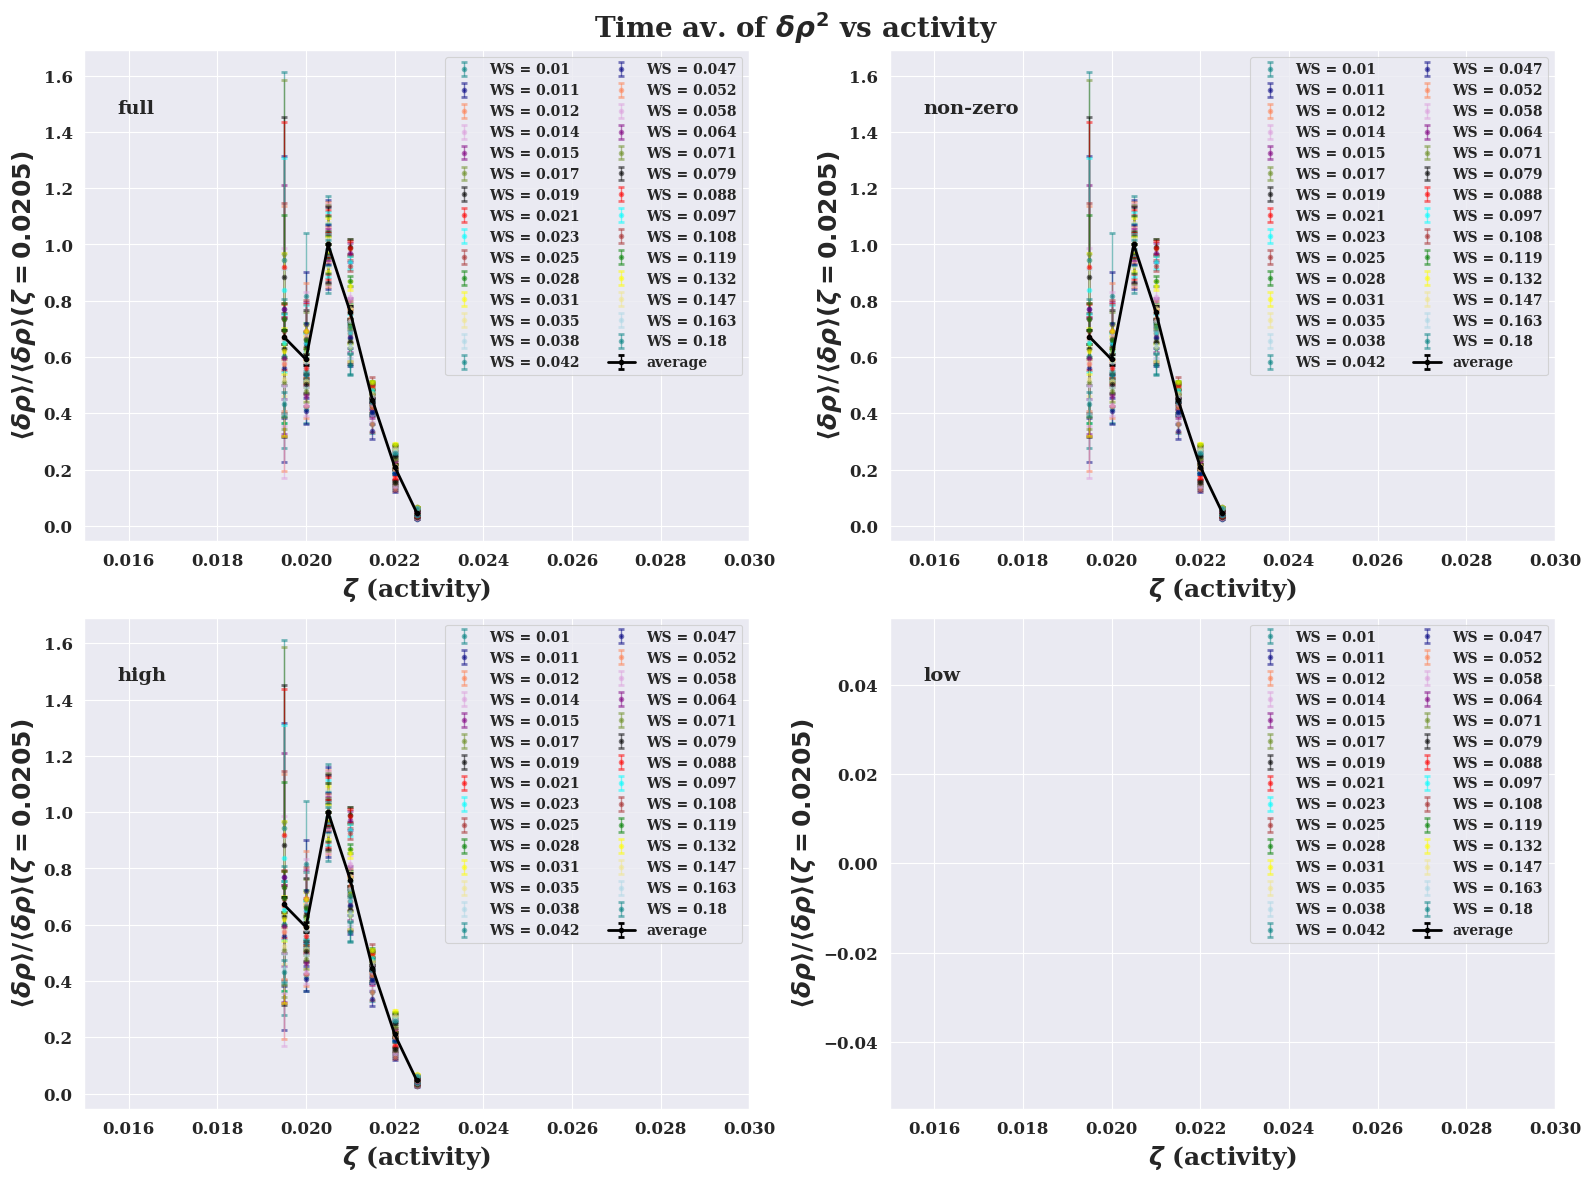

In [76]:

av_dens_arr = defect_arr_long / (LX ** 2)
dens_fluc_full = dens_fluc_long / av_dens_arr[:, None, :, :] ** 2
dens_fluc_full_av = np.nanmean(dens_fluc_full, axis = 3)
dens_fluc_full_std = np.nanstd(dens_fluc_full, axis = 3) / np.sqrt((~np.isnan(defect_arr_long[0,:,:])).sum(axis=-1))[None, None, :,]
xi_av_full = np.nanmean(dens_fluc_full_av, axis = 0)
xi_std_full = np.nanstd(dens_fluc_full_av, axis = 0) / np.sqrt(Nframes_long)

# save xi
np.savetxt(os.path.join(save_path, 'xi_av_full_very_long.txt'), xi_av_full)
np.savetxt(os.path.join(save_path, 'xi_std_full_very_long.txt'), xi_std_full)
# save dens_fluc_full av and std
np.save(os.path.join(save_path, 'dens_fluc_full_av_very_long.npy'), dens_fluc_full_av)
np.save(os.path.join(save_path, 'dens_fluc_full_std_very_long.npy'), dens_fluc_full_std)

var_counts_long_av = np.nanmean(var_counts_long, axis = 3)
var_counts_long_std = np.nanstd(var_counts_long, axis = 3) / np.sqrt((~np.isnan(defect_arr_long[0,:,:])).sum(axis=-1))[None, None, :,]

# save var_counts_long av and std
np.save(os.path.join(save_path, 'var_counts_long_av_very_long.npy'), var_counts_long_av)
np.save(os.path.join(save_path, 'var_counts_long_std_very_long.npy'), var_counts_long_std)

av_dens_arr_non_zero = defect_arr_long_non_zero / (LX ** 2)
dens_fluc_full_non_zero = var_counts_long / (np.pi * window_sizes[:, None, None] ** 2) ** 2 / av_dens_arr_non_zero[:, None, :, :] ** 2
dens_fluc_full_av_non_zero = np.nanmean(dens_fluc_full_non_zero, axis = 3)
dens_fluc_full_std_non_zero = np.nanstd(dens_fluc_full_non_zero, axis = 3) / np.sqrt((~np.isnan(defect_arr_long_non_zero[0,:,:])).sum(axis=-1))[None, None, :,]
xi_av_full_non_zero = np.nanmean(dens_fluc_full_av_non_zero, axis = 0)
xi_std_full_non_zero = np.nanstd(dens_fluc_full_av_non_zero, axis = 0) / np.sqrt(Nframes_long)



av_dens_arr_high = defect_arr_high / (LX ** 2)
dens_fluc_full_high = var_counts_long / (np.pi * window_sizes[:, None, None] ** 2) ** 2 / av_dens_arr_high[:, None, :, :] ** 2
dens_fluc_full_av_high = np.nanmean(dens_fluc_full_high, axis = 3)
dens_fluc_full_std_high = np.nanstd(dens_fluc_full_high, axis = 3)  / np.sqrt((~np.isnan(defect_arr_high[0,:,:])).sum(axis=-1))
xi_av_full_high = np.nanmean(dens_fluc_full_av_high, axis = 0)
xi_std_full_high = np.nanstd(dens_fluc_full_av_high, axis = 0) / np.sqrt(Nframes_long)

av_dens_arr_mid = defect_arr_mid / (LX ** 2)
dens_fluc_full_mid = var_counts_long / (np.pi * window_sizes[:, None, None] ** 2) ** 2 / av_dens_arr_mid[:, None, :, :] ** 2
dens_fluc_full_av_mid = np.nanmean(dens_fluc_full_mid, axis = 3)
dens_fluc_full_std_mid = np.nanstd(dens_fluc_full_mid, axis = 3) / np.sqrt((~np.isnan(defect_arr_mid[0,:,:])).sum(axis=-1))
xi_av_full_mid = np.nanmean(dens_fluc_full_av_mid, axis = 0)
xi_std_full_mid = np.nanstd(dens_fluc_full_av_mid, axis = 0) / np.sqrt(Nframes_long)


logplot = False

fig, ax = plt.subplots(ncols = 2, nrows = 2, figsize=(16,12))
ax = ax.flatten()

xi_av_list = [xi_av_full, xi_av_full_non_zero, xi_av_full_high, xi_av_full_mid]
xi_std_list = [xi_std_full, xi_std_full_non_zero, xi_std_full_high, xi_std_full_mid]
label_list = ['full', 'non-zero', 'high', 'low']    

min_act_cutoff_idx = 0
min_window_cutoff_idx = 0
max_window_cutoff_idx = 29
act_max_idx = act_list_long.index(0.0205)

for i, (xi_av, xi_std) in enumerate(zip(xi_av_list, xi_std_list)):

    xi_av_vals = np.zeros( (len(window_sizes[min_window_cutoff_idx:max_window_cutoff_idx]), len(act_list_long[min_act_cutoff_idx:]) ))
    xi_std_vals = np.zeros( (len(window_sizes[min_window_cutoff_idx:max_window_cutoff_idx]), len(act_list_long[min_act_cutoff_idx:]) ))
    for j, window in enumerate(window_sizes[min_window_cutoff_idx:]):
        if window >= window_sizes[max_window_cutoff_idx]:
             continue
        norm =  xi_av[j + min_window_cutoff_idx, act_max_idx]
        if j % 1 == 0: #in [1,2,3,4,5,6,7]:
            ax[i].errorbar(act_list_long[min_act_cutoff_idx:], xi_av[j + min_window_cutoff_idx, min_act_cutoff_idx:] / norm,\
                            xi_std[j + min_window_cutoff_idx, min_act_cutoff_idx:] / norm, label=f'WS = {np.round(window / 256,3)}', fmt='.', \
                   capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 0.5, markersize=4)

        xi_av_vals[j,:] = xi_av[j + min_window_cutoff_idx, min_act_cutoff_idx:] / norm
        xi_std_vals[j,:] = xi_std[j + min_window_cutoff_idx, min_act_cutoff_idx:] / norm

    # plot average xi
    xi_av_vals_mean = np.nanmean(xi_av_vals, axis = 0)
    xi_av_vals_std = np.nanstd(xi_av_vals, axis = 0) / np.sqrt(xi_av_vals.shape[0])
    ax[i].errorbar(act_list_long[min_act_cutoff_idx:], xi_av_vals_mean, xi_av_vals_std, label='average', fmt='.-', \
                   capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 1, markersize=4, color='black')

    ax[i].set_xlabel(rf'$\zeta$ (activity)')
    ax[i].set_ylabel(rf'$\langle \delta \rho \rangle / \langle \delta \rho \rangle (\zeta = {act_list_long[act_max_idx]}) $')
    ax[i].set_xlim(0.015,0.03)
    ax[i].text(0.05, 0.9, f'{label_list[i]}', transform=ax[i].transAxes, fontsize=14, verticalalignment='top'
    )

    if logplot:
      #  ax.set_yscale('log')
        ax[i].set_xscale('log')

    #add legend above the plot in 3 rows
    ax[i].legend(loc='upper right', ncol=2, fontsize = 10,)



fig.suptitle(rf'Time av. of $\delta \rho ^2$ vs activity', fontsize=20)
fig.tight_layout()
plt.show()

C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_8684\4157953219.py:7: RuntimeWarning: Mean of empty slice
  binder_tot_mid = 1 - np.nanmean(np.nanmean(defect_arr_mid[:,:,:] ** 4, axis = -1), axis = 0) \
C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_8684\4157953219.py:8: RuntimeWarning: Mean of empty slice
  / (3 * np.nanmean(np.nanmean(defect_arr_mid[:,:,:] ** 2, axis = -1), axis = 0) ** 2)


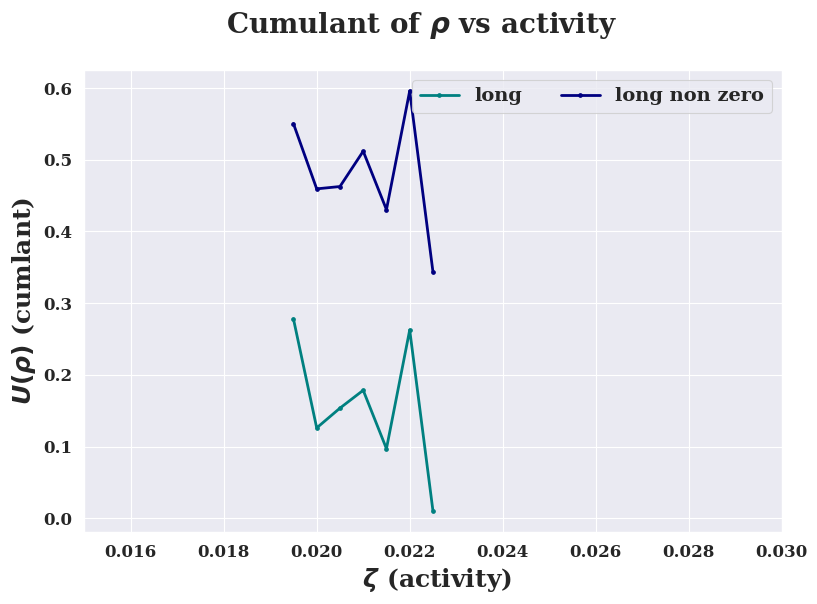

In [77]:
binder_tot_long = 1 - np.nanmean(np.nanmean(defect_arr_long[:,:,:] ** 4, axis = -1), axis = 0) \
  / (3 * np.nanmean(np.nanmean(defect_arr_long[:,:,:] ** 2, axis = -1), axis = 0) ** 2)
binder_tot_long_non_zero = 1 - np.nanmean(np.nanmean(defect_arr_long_non_zero[:,:,:] ** 4, axis = -1), axis = 0) \
  / (3 * np.nanmean(np.nanmean(defect_arr_long_non_zero[:,:,:] ** 2, axis = -1), axis = 0) ** 2)
binder_tot_high = 1 - np.nanmean(np.nanmean(defect_arr_high[:,:,:] ** 4, axis = -1), axis = 0) \
  / (3 * np.nanmean(np.nanmean(defect_arr_high[:,:,:] ** 2, axis = -1), axis = 0) ** 2)
binder_tot_mid = 1 - np.nanmean(np.nanmean(defect_arr_mid[:,:,:] ** 4, axis = -1), axis = 0) \
  / (3 * np.nanmean(np.nanmean(defect_arr_mid[:,:,:] ** 2, axis = -1), axis = 0) ** 2)

# save binder_tot
np.savetxt(os.path.join(save_path, 'binder_tot_very_long.txt'), binder_tot_long)

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(act_list_long, 2/3 - binder_tot_long, '.-', label='long')
ax.plot(act_list_long, 3/3- binder_tot_long_non_zero, '.-', label='long non zero')



ax.set_xlim(0.015, 0.03)
ax.set_xlabel(r' $\zeta$ (activity)')
ax.set_ylabel(r'$U(\rho)$ (cumlant)')
ax.legend(loc='upper right', ncol=2, fontsize = 14)
fig.suptitle(rf'Cumulant of $\rho$ vs activity', fontsize=20)

plt.show()

[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]


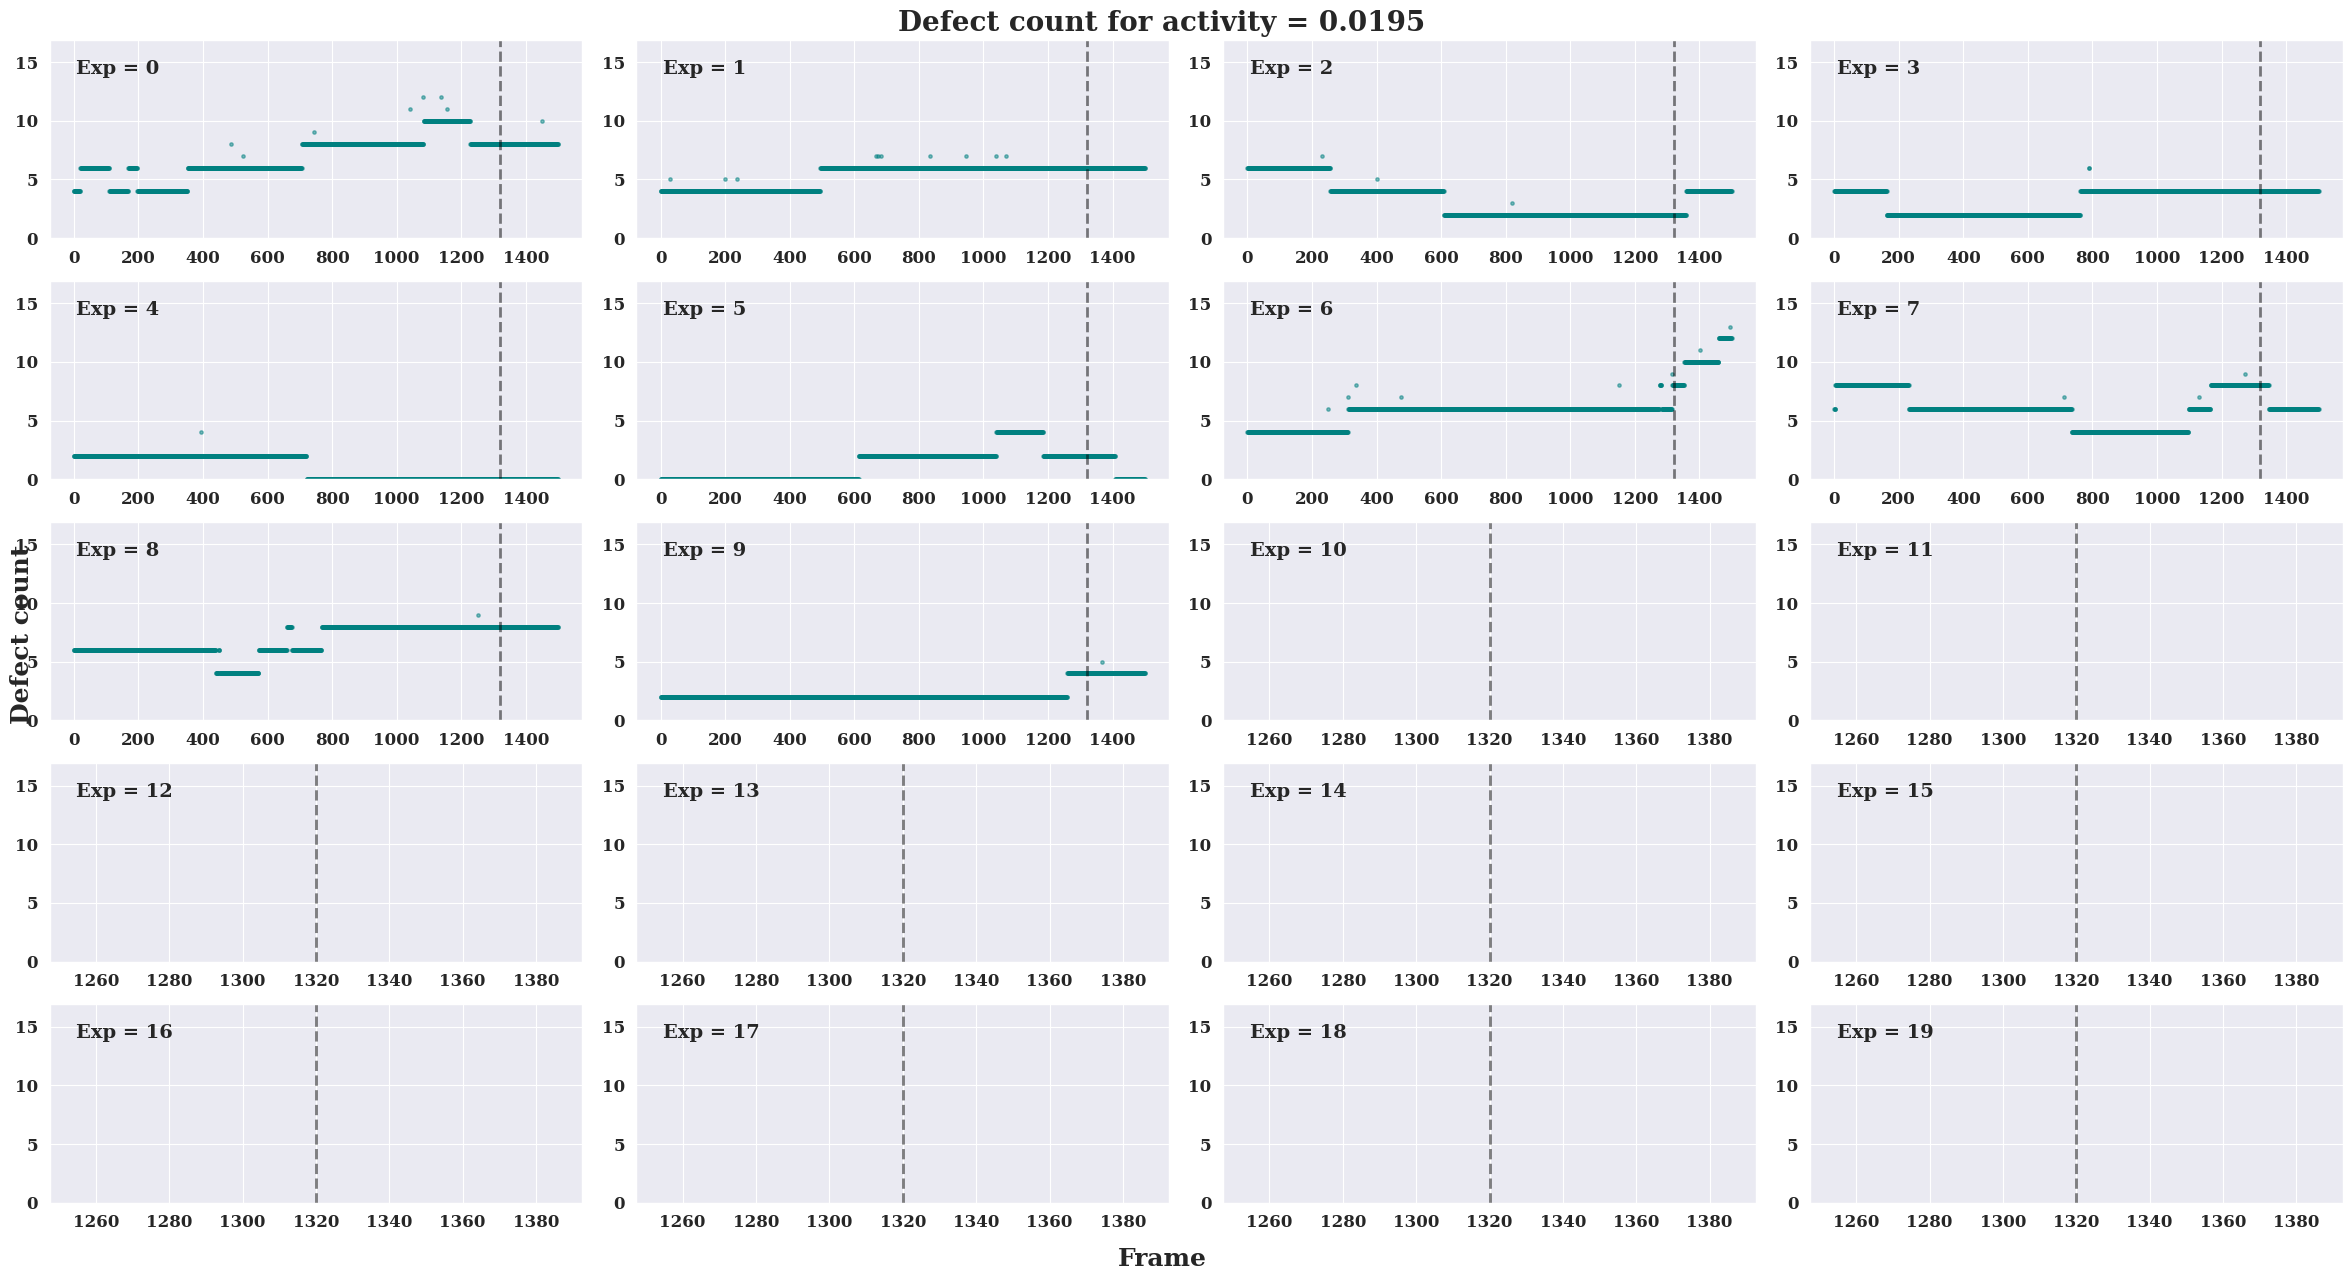

KeyboardInterrupt: Interrupted by user

In [16]:
act_idx = 8
ncols = 4
nrows = 5


for act_idx in np.arange(Nactivity_long):
    if act_idx < 0:
        continue
    
    fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize=(24, 13))
    ax = ax.flatten()
    mini, maxi = np.nanmin(defect_arr_long[:, act_idx, :]), np.nanmax(defect_arr_long[:, act_idx, : ])
    for i in np.arange(Nexp_long):
        ax[i].plot(np.arange(Nframes_long), defect_arr_long[:, act_idx, i], '.', label='exp = {}'.format(i), alpha = 0.5)
        
        # plot vertical lines to indicate the start of the averaging
        #x_conv, converged = est_stationarity(defect_arr_long[:, act_idx, i], 50, 15, 250, 1)
        x_conv = Nframes_long - 181
        ax[i].axvline(x=x_conv, color='black', linestyle='--', alpha=0.5)
        ax[i].set_ylim(0.7 * mini, 1.3 * maxi)

    #   print(i, converged)

        ax[i].text(0.05, 0.9, 'Exp = {}'.format(i), transform=ax[i].transAxes, fontsize=14, verticalalignment='top')


    fig.suptitle('Defect count for activity = {}'.format(act_list_long[act_idx]))
    fig.supxlabel('Frame')
    fig.supylabel('Defect count')

    #ax[-1].axis('off')
    #ax[-2].axis('off')
    
    plt.tight_layout()
    
    

    print(exp_conv_list_long[:4, act_idx])
    print(exp_conv_list_long[4:8, act_idx])
    print(exp_conv_list_long[8:12, act_idx])
    print(exp_conv_list_long[12:16, act_idx])
    print(exp_conv_list_long[16:, act_idx])

    plt.show()

    conv = input(f'Enter exp Numbers not converged in format x1,x2,x3,... for  act {act_list_long[act_idx]}')
    if len(conv) > 0:
        conv = np.array(conv.split(',')).astype(int)
        exp_conv_list_long[conv, act_idx] = -1
    conv = input(f'Enter exp Numbers not proliferated at all in format x1,x2,x3,... for  act {act_list_long[act_idx]}')
    if len(conv) > 0:
        conv = np.array(conv.split(',')).astype(int)
        exp_conv_list_long[conv, act_idx] = 0
    conv = input(f'Enter exp Numbers not proliferated fully in format x1,x2,x3,... for  act {act_list_long[act_idx]}')
    if len(conv) > 0:
        conv = np.array(conv.split(',')).astype(int)
        print(conv)
        exp_conv_list_long[conv, act_idx] = 2



In [22]:
exp_conv_list_long

array([[ 1.,  2.,  2.,  2., -1.,  2.,  0., -1.,  1.,  1.,  1.],
       [ 1.,  2.,  2.,  1.,  2.,  2.,  2.,  1.,  1.,  1.,  1.],
       [ 1., nan,  2.,  2.,  1.,  2.,  0.,  1.,  1.,  1.,  1.],
       [nan,  1.,  1.,  1.,  0.,  2.,  1.,  1.,  1.,  1.,  1.],
       [nan,  2.,  2.,  0.,  0.,  1.,  0.,  2.,  1.,  1.,  1.],
       [nan,  0.,  0., -1.,  1.,  1.,  0.,  2.,  1.,  1.,  1.],
       [nan,  1.,  2.,  0.,  2.,  2.,  0., -1.,  1.,  1.,  1.],
       [ 0.,  2.,  2.,  2.,  2.,  1.,  0., -1., -1.,  1.,  1.],
       [ 1., nan,  2.,  2., -1.,  2.,  2.,  0., -1.,  1.,  1.],
       [ 1.,  0.,  2., nan,  2.,  0.,  0.,  1., -1.,  1.,  1.],
       [ 1.,  2.,  0., -1.,  0.,  1.,  2., -1.,  1.,  1.,  1.],
       [nan, nan,  1.,  1.,  1.,  1.,  1.,  2.,  1.,  1.,  1.],
       [ 1.,  0.,  1.,  2.,  2.,  1.,  2.,  2.,  1.,  1.,  1.],
       [ 1., nan, -1., nan, -1.,  0.,  0., -1., -1.,  1.,  1.],
       [nan,  1.,  0.,  2.,  2.,  0.,  0., -1., -1.,  1.,  1.],
       [nan,  1.,  0.,  2.,  1.,  2.,  2

In [176]:

exp_conv_list = np.ones((Nexp, Nactivity)).astype(float)
exp_conv_list[:, 6:12] = np.nan

conv_act0021 = np.array([7])
conv_act00215 = np.array([5,6,7])
conv_act0022 = np.array([0,2,5,8])
conv_act00225 = np.array([0,1, 2, 3])
conv_act0023 = np.array([3,4])
conv_act00235 = np.array([0,2,4,6,7,8,9])

exp_conv_list[conv_act0021, 6] = 1
exp_conv_list[conv_act00215, 7] = 1
exp_conv_list[conv_act0022, 8] = 1
exp_conv_list[conv_act00225, 9] = 1
exp_conv_list[conv_act0023, 10] = 1
exp_conv_list[conv_act00235, 11] = 1

In [8]:
exp_conv_list = np.ones((Nexp, Nactivity)).astype(float)

In [9]:
# load arrays
normalize = True
save = True
act_to_remove = []

idx_exp_to_keep_list = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
idx_act_to_keep_list = np.where(~np.isin(act_list, act_to_remove))[0]
conv_list = np.delete(conv_list, np.where(np.isin(act_list, act_to_remove))[0])
                 
conv_dict = dict(zip(act_list, conv_list))
act_list = list(np.delete(act_list, np.where(np.isin(act_list, act_to_remove))[0]))
Nactivity = len(act_list)
Nexp = len(idx_exp_to_keep_list)

window_sizes = np.loadtxt(os.path.join(path0, 'window_sizes.txt'))

defect_arr = np.load(os.path.join(save_path, 'defect_arr.npy'))[:, :, idx_exp_to_keep_list][:, idx_act_to_keep_list, :] / LX ** 2
defect_arr_conv = defect_arr * exp_conv_list.T[np.newaxis, :Nactivity, :]

av_defects = np.zeros((Nactivity, 2)) 
defect_arr_av = np.mean(defect_arr, axis=2)
defect_arr_std = np.std(defect_arr, axis=2)

av_defects_conv = np.zeros((Nactivity, 2))
defect_arr_av_conv = np.nanmean(defect_arr_conv, axis=2)
defect_arr_std_conv = np.nanstd(defect_arr_conv, axis=2)

for i, act in enumerate(act_list):
    av_defects[i, 0] = np.mean(defect_arr_av[conv_dict[act]:, i])
    av_defects[i, 1] = np.mean(defect_arr_std[conv_dict[act]:, i]) / np.sqrt(Nframes - conv_dict[act])
    av_defects_conv[i, 0] = np.mean(defect_arr_av_conv[conv_dict[act]:, i])
    av_defects_conv[i, 1] = np.mean(defect_arr_std_conv[conv_dict[act]:, i]) 
av_defects_conv[:, 1] = av_defects_conv[:, 1] / np.sqrt(np.nanmean(exp_conv_list, axis=0))[:Nactivity]


av_counts = np.load(os.path.join(save_path, 'av_counts.npy'))[:, :, :, idx_exp_to_keep_list][:, :, idx_act_to_keep_list, :]
av_counts = av_counts * exp_conv_list.T[np.newaxis, np.newaxis, :Nactivity, :]
av_counts_av = np.nanmean(av_counts, axis=3)
av_counts_std = np.nanstd(av_counts, axis=3, ddof=1) / (np.sqrt(np.nanmean(exp_conv_list, axis=0))[:Nactivity])[None, None, :]

var_counts = np.load(os.path.join(save_path, 'var_counts.npy'))[:, :, :, idx_exp_to_keep_list][:, :, idx_act_to_keep_list, :]
var_counts = var_counts * exp_conv_list.T[np.newaxis, np.newaxis, :Nactivity, :]
var_counts_av = np.nanmean(var_counts, axis=3)
var_counts_std = np.nanstd(var_counts, axis=3, ddof=1) / (np.sqrt(np.nanmean(exp_conv_list, axis=0))[:Nactivity])[None, None, :]

dens_fluc = np.load(os.path.join(save_path, 'dens_fluc.npy'))[:, :, :, idx_exp_to_keep_list][:, :, idx_act_to_keep_list, :]
dens_fluc = dens_fluc * exp_conv_list.T[np.newaxis, np.newaxis, :Nactivity, :]
dens_fluc_av = np.nanmean(dens_fluc, axis=3)
dens_fluc_std = np.nanstd(dens_fluc, axis=3, ddof=1) / (np.sqrt(np.nanmean(exp_conv_list, axis=0))[:Nactivity])[None, None, :]

if normalize:
    dens_fluc = dens_fluc / defect_arr[:, None, :, :] ** 2
    dens_fluc_av = np.nanmean(dens_fluc, axis=3)
    dens_fluc_std = np.nanstd(dens_fluc, axis=3, ddof=1) / (np.sqrt(np.nanmean(exp_conv_list, axis=0))[:Nactivity])[None, None, :]

if save:
    np.save(os.path.join(save_path, 'av_counts_av.npy'), av_counts_av)
    np.save(os.path.join(save_path, 'av_counts_std.npy'), av_counts_std)
    np.save(os.path.join(save_path, 'var_counts_av.npy'), var_counts_av)
    np.save(os.path.join(save_path, 'var_counts_std.npy'), var_counts_std)
    np.save(os.path.join(save_path, 'dens_fluc_av.npy'), dens_fluc_av)
    np.save(os.path.join(save_path, 'dens_fluc_std.npy'), dens_fluc_std)
    np.save(os.path.join(save_path, 'av_defects.npy'), av_defects)
    np.save(os.path.join(save_path, 'av_defects_conv.npy'), av_defects_conv)


C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_2460\2875794715.py:38: RuntimeWarning: Mean of empty slice
  av_counts_av = np.nanmean(av_counts, axis=3)
c:\Users\Simon Andersen\miniconda3\envs\sf\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_2460\2875794715.py:43: RuntimeWarning: Mean of empty slice
  var_counts_av = np.nanmean(var_counts, axis=3)
C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_2460\2875794715.py:48: RuntimeWarning: Mean of empty slice
  dens_fluc_av = np.nanmean(dens_fluc, axis=3)
C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_2460\2875794715.py:53: RuntimeWarning: Mean of empty slice
  dens_fluc_av = np.nanmean(dens_fluc, axis=3)


In [10]:
min_window_idx=0
first_frame_list = np.array(conv_list)
Nframes_non_nan_counts = Nframes - np.array(first_frame_list)

min_act_idx = 10


In [11]:
act_list[min_act_idx]

0.0215

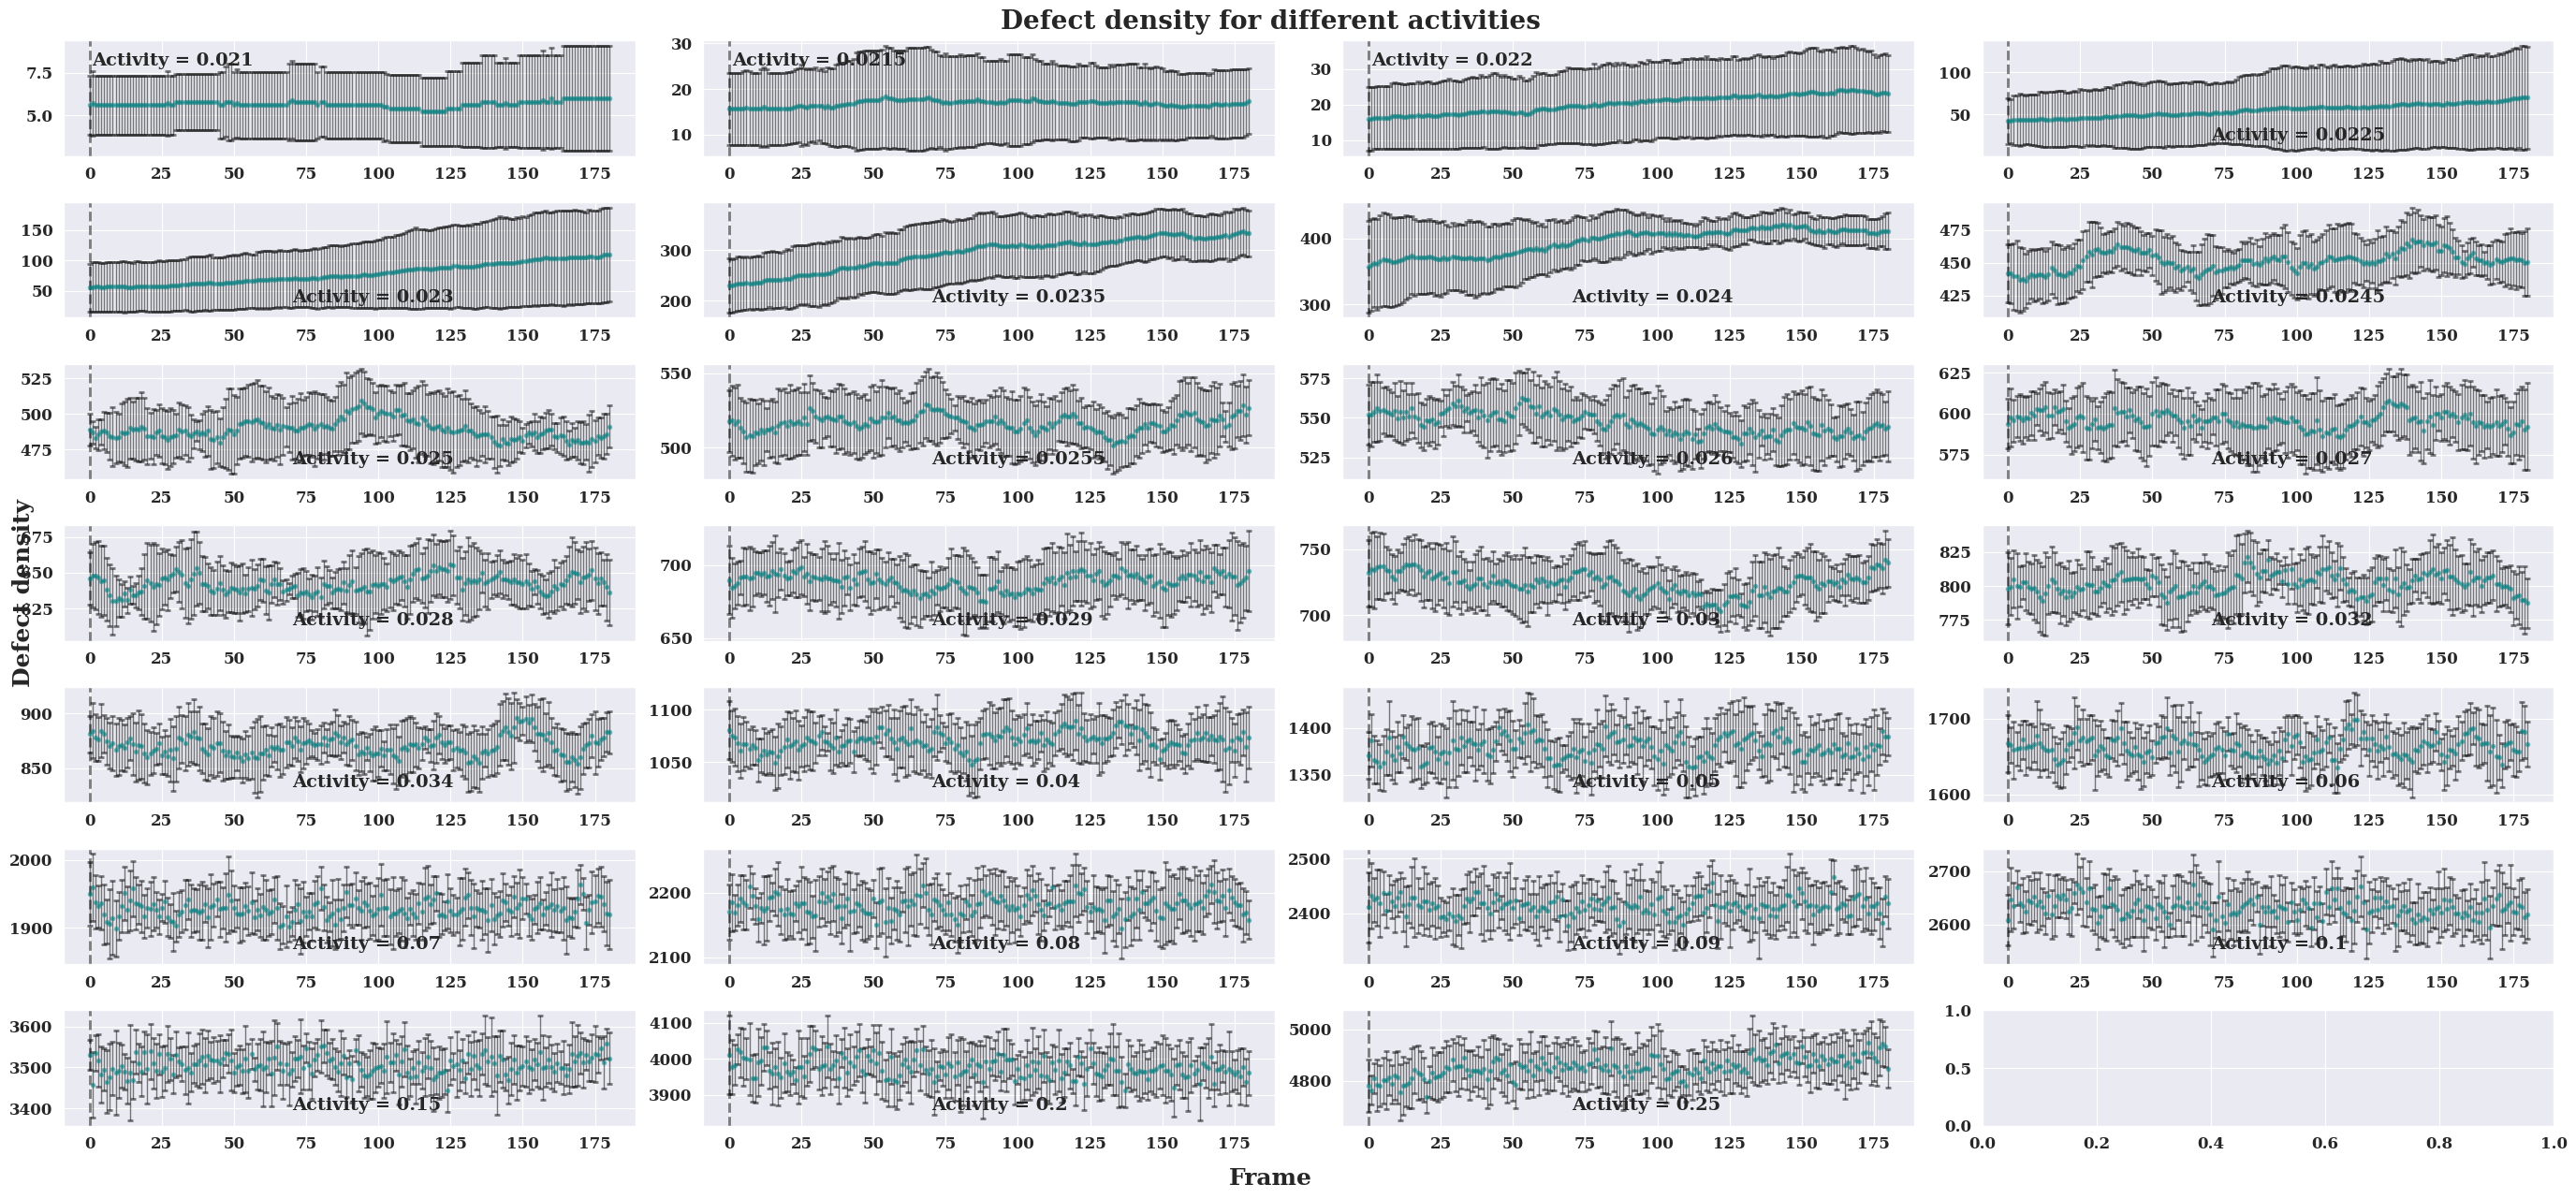

In [54]:
ncols = 4
nrows = int(np.ceil(Nactivity / ncols))
nrows = 7
fig, ax = plt.subplots(nrows = nrows, ncols = 4, figsize=(28, 13))
ax = ax.flatten()
for i, act in enumerate(act_list[min_act_idx+2:min_act_idx+2 + 28]):
    act_idx = act_list.index(act)
    ax[i].errorbar(np.arange(Nframes), defect_arr_av_conv[:, act_idx] * LX**2, defect_arr_std_conv[:, act_idx] * LX**2, label='activity = {}'.format(act), fmt='.', \
                   capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 0.5, markersize=4, ecolor='black')
    
    # plot vertical lines to indicate the start of the averaging
    ax[i].axvline(x=conv_dict[act], color='black', linestyle='--', alpha=0.5)
    #ax[i].set_ylim(np.nanmin(defect_arr_av_conv[:, act_idx])/2, np.nanmax(defect_arr_av_conv[:, act_idx]) + 2  * np.nanmax(defect_arr_std[:, act_idx]))


    if i < 3:
        ax[i].text(0.05, 0.9, 'Activity = {}'.format(act), transform=ax[i].transAxes, fontsize=14, verticalalignment='top')
    else:
        ax[i].text(0.4, 0.1, 'Activity = {}'.format(act), transform=ax[i].transAxes, fontsize=14, verticalalignment='bottom')

fig.suptitle('Defect density for different activities')
fig.supxlabel('Frame')
fig.supylabel('Defect density')

#ax[-1].axis('off')
#ax[-2].axis('off')


plt.tight_layout()
plt.show()

In [95]:
var_counts[:,:,-1,-1].shape

(181, 30)

In [130]:
for act_idx in np.arange(var_counts.shape[-2]):
    for frame in np.arange(var_counts.shape[0]):
        nans = np.isnan(var_counts_av[frame, :, act_idx])
        if nans.sum() > 0 and act_list[act_idx] > 0.019:
            print("For activity {} and frame {} there are {} nan values in var_counts_av".format(act_list[act_idx], frame, nans.sum()))


For activity 0.0195 and frame 35 there are 30 nan values in var_counts_av
For activity 0.0195 and frame 36 there are 30 nan values in var_counts_av
For activity 0.0195 and frame 37 there are 30 nan values in var_counts_av
For activity 0.0195 and frame 38 there are 30 nan values in var_counts_av
For activity 0.0195 and frame 39 there are 30 nan values in var_counts_av
For activity 0.02 and frame 163 there are 30 nan values in var_counts_av
For activity 0.02 and frame 164 there are 30 nan values in var_counts_av
For activity 0.02 and frame 165 there are 30 nan values in var_counts_av
For activity 0.02 and frame 166 there are 30 nan values in var_counts_av
For activity 0.02 and frame 167 there are 30 nan values in var_counts_av
For activity 0.02 and frame 168 there are 30 nan values in var_counts_av
For activity 0.02 and frame 169 there are 30 nan values in var_counts_av
For activity 0.02 and frame 170 there are 30 nan values in var_counts_av
For activity 0.02 and frame 171 there are 30 n

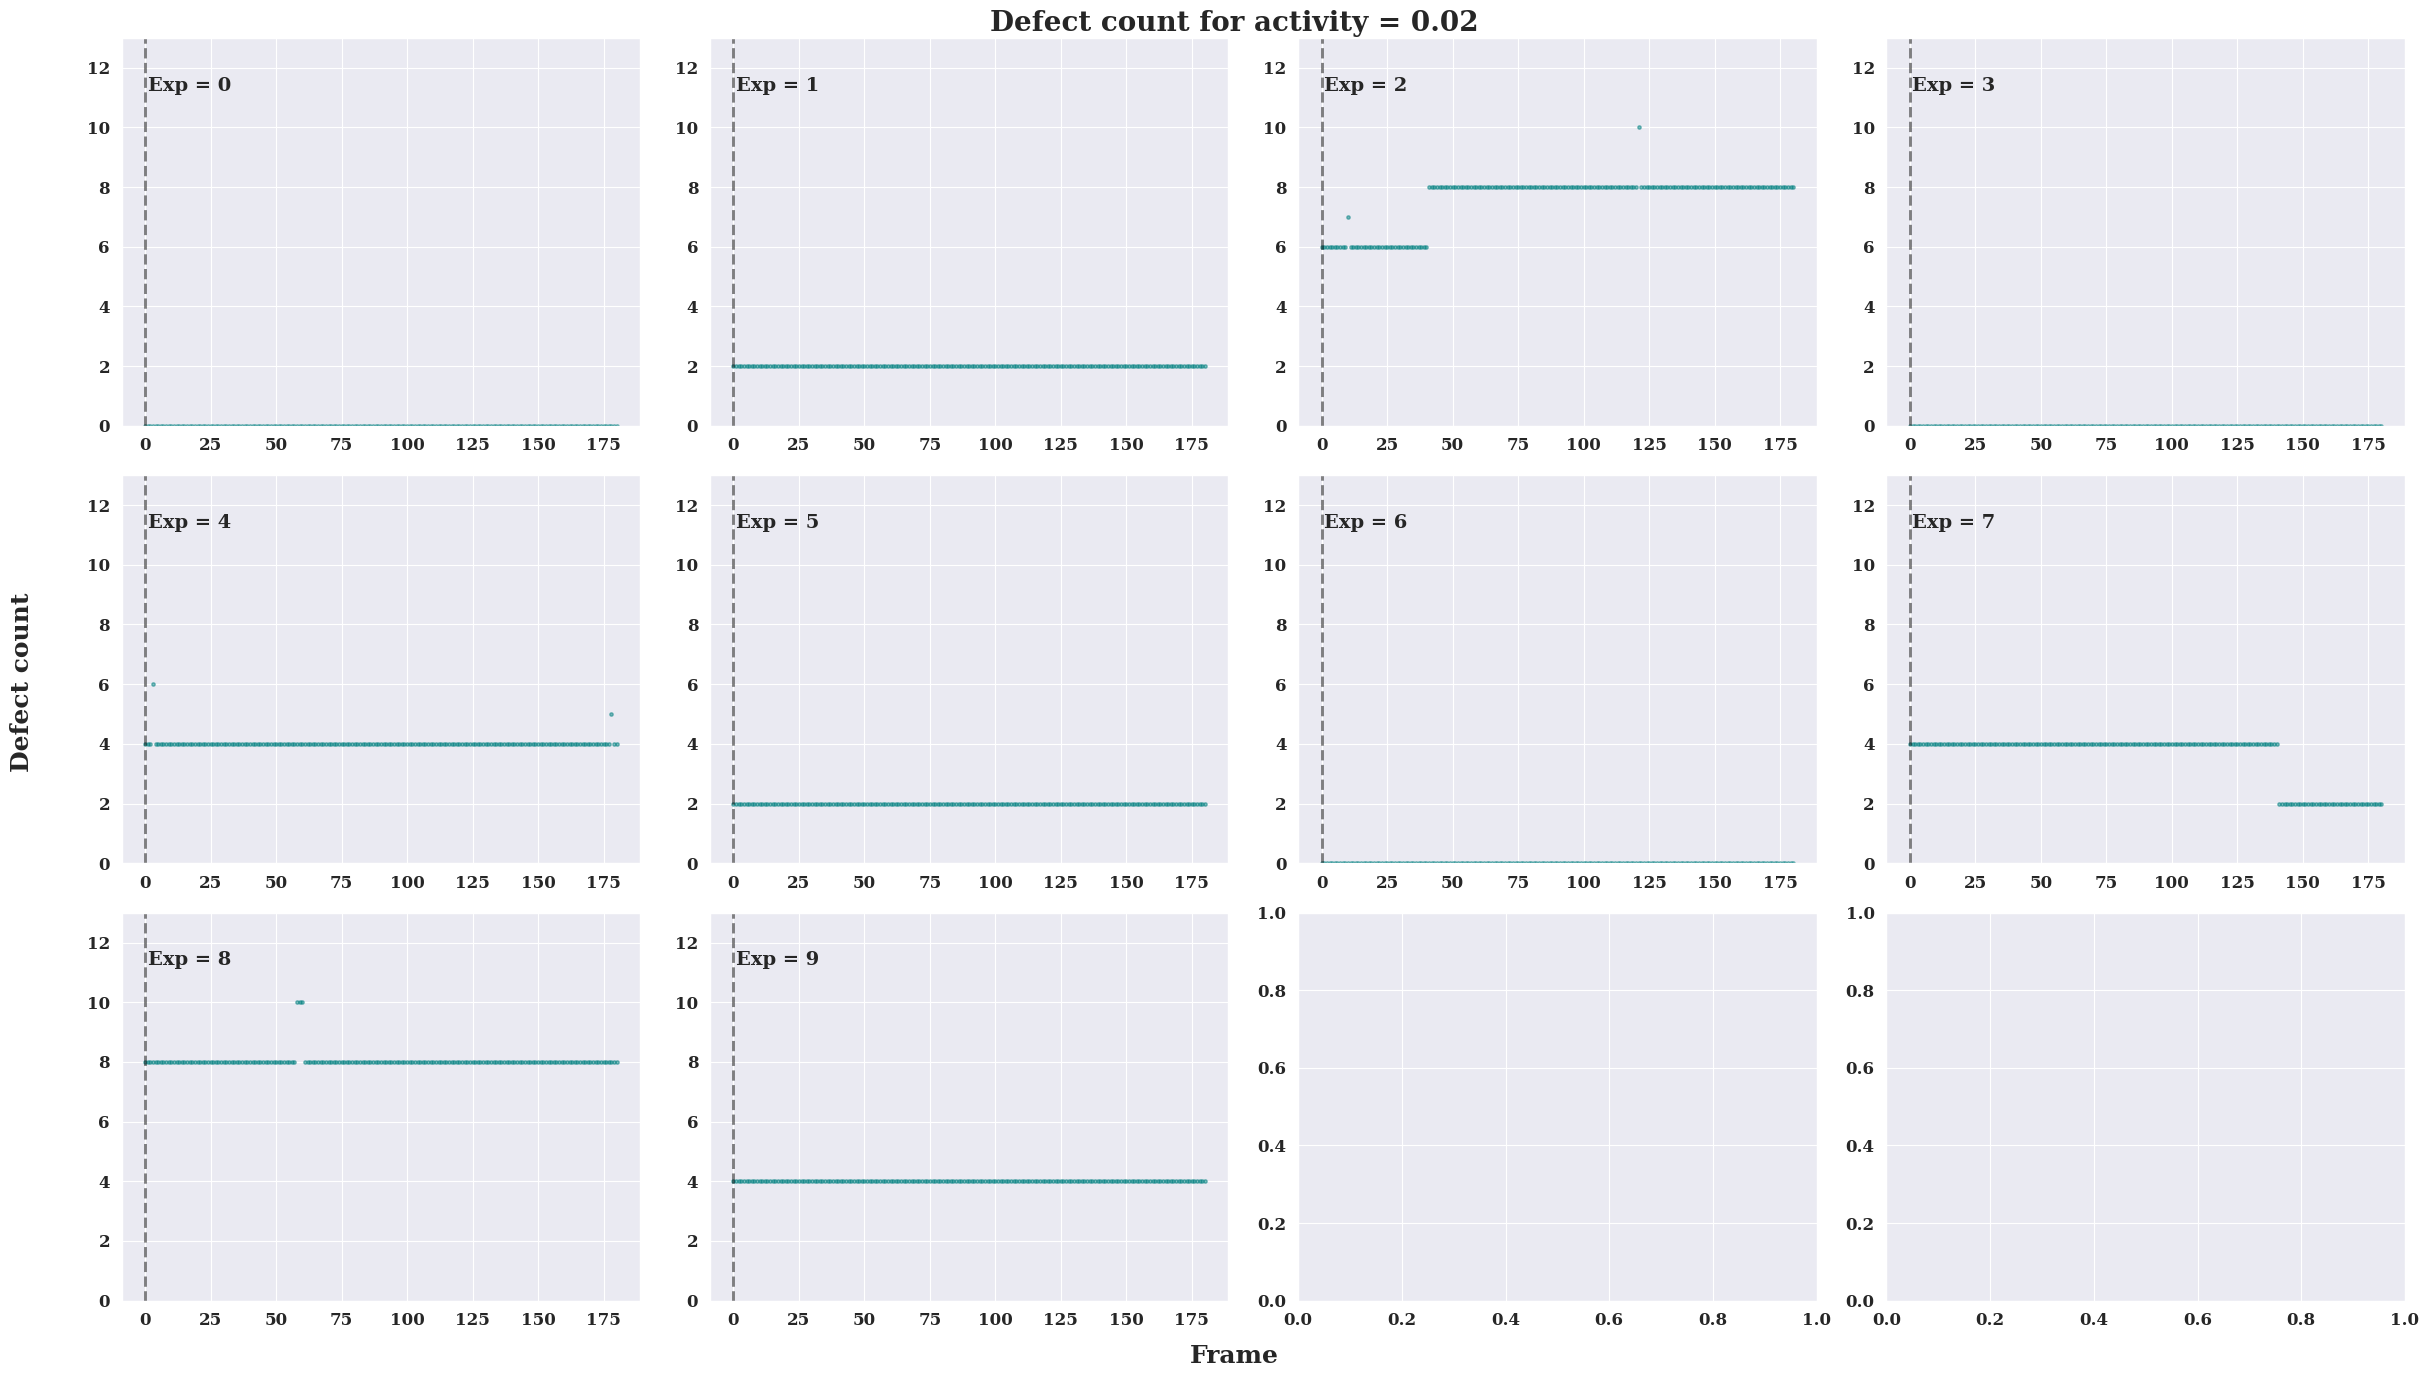

In [241]:
act_idx = 7
ncols = 4
nrows = int(np.ceil(Nactivity / ncols))
nrows = 3
fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize=(24, 14))
ax = ax.flatten()
for i in np.arange(Nexp):
    ax[i].plot(np.arange(Nframes), defect_arr[:, act_idx, i] * LX**2, '.', label='exp = {}'.format(i), alpha = 0.5)
    
    # plot vertical lines to indicate the start of the averaging
    ax[i].axvline(x=conv_dict[act], color='black', linestyle='--', alpha=0.5)
    ax[i].set_ylim(0, max(np.nanmax(defect_arr[:, act_idx, :] * LX ** 2), 3) * 1.3)


    ax[i].text(0.05, 0.9, 'Exp = {}'.format(i), transform=ax[i].transAxes, fontsize=14, verticalalignment='top')

fig.suptitle('Defect count for activity = {}'.format(act_list[act_idx]))
fig.supxlabel('Frame')
fig.supylabel('Defect count', x = -0.01)

#ax[-1].axis('off')
#ax[-2].axis('off')


plt.tight_layout()
plt.show()

In [160]:
def linear(x, a, b):
    return a * x + b
# Try fitting with other functions
def qudratic(x, a, b, c):
    return a * x**2 + b * x + c
def power(x, a, b, c, d):
    return a * x**d + b * x + c
def log_func(x, a, b, c):
    return a * np.log(x) + b*x + c

In [161]:
# do a linear fit to the average defect density
param_guess_lin = np.array([70 * 100, 100])
param_guess_quad = np.array([70 * 100, 100, 0])
param_guess_power = np.array([7000, 2, 7100, -29])
param_guess_log = np.array([7000, 300, 30])
fit_func = log_func
fit_string = rf'$y = a x^2 + bx + c$'
fit_string = rf'$y = a \ln x + bx + c $'

param_guess = param_guess_log / LX ** 2
# fit starting with different lower activity values
for i in range(0, len(act_list) - 1):
    lin_fit = do_chi2_fit(fit_func, act_list[i:], av_defects_conv[i:, 0], av_defects_conv[i:, 1], parameter_guesses= param_guess, verbose=False)

    print("Fitting only activities >= {}".format(act_list[i]))
    Ndof, chi2, pval = get_statistics_from_fit(lin_fit, len(act_list[i:]))
    print("Ndof, chi2, pval: ", Ndof, np.round(chi2, 2), np.round(pval, 7))
print("\n\n")

 
lower_act_index = act_list.index(0.0235)

lin_fit = do_chi2_fit(fit_func, act_list[lower_act_index:], av_defects_conv[lower_act_index:, 0], av_defects_conv[lower_act_index:, 1], parameter_guesses= param_guess, verbose=False)
Ndof, chi2, pval = get_statistics_from_fit(lin_fit, len(act_list[lower_act_index:]))


Fitting only activities >= 0.01
Ndof, chi2, pval:  34 12033.1 0.0
Fitting only activities >= 0.012
Ndof, chi2, pval:  33 12006.77 0.0
Fitting only activities >= 0.014
Ndof, chi2, pval:  32 11882.75 0.0
Fitting only activities >= 0.016
Ndof, chi2, pval:  31 10533.71 0.0
Fitting only activities >= 0.018
Ndof, chi2, pval:  30 6240.07 0.0
Fitting only activities >= 0.019
Ndof, chi2, pval:  29 3519.8 0.0
Fitting only activities >= 0.0195
Ndof, chi2, pval:  28 1789.48 0.0
Fitting only activities >= 0.02
Ndof, chi2, pval:  27 1255.26 0.0
Fitting only activities >= 0.0205
Ndof, chi2, pval:  26 908.76 0.0
Fitting only activities >= 0.021
Ndof, chi2, pval:  25 848.4 0.0
Fitting only activities >= 0.0215
Ndof, chi2, pval:  24 746.05 0.0
Fitting only activities >= 0.022
Ndof, chi2, pval:  23 576.34 0.0
Fitting only activities >= 0.0225
Ndof, chi2, pval:  22 108.49 0.0
Fitting only activities >= 0.023
Ndof, chi2, pval:  21 63.62 3.6e-06
Fitting only activities >= 0.0235
Ndof, chi2, pval:  20 33.95 

C:\Users\Simon Andersen\Projects\Projects\Appstat2022\External_Functions\ExternalFunctions.py:113: VisibleDeprecationWarning: make_func_code is deprecated: Use of ``func_code`` attribute to declare parameters is deprecated. Use ``_parameters`` instead, which is a dict of parameter names to limits.
  self.func_code = make_func_code(describe(self.f)[1:])


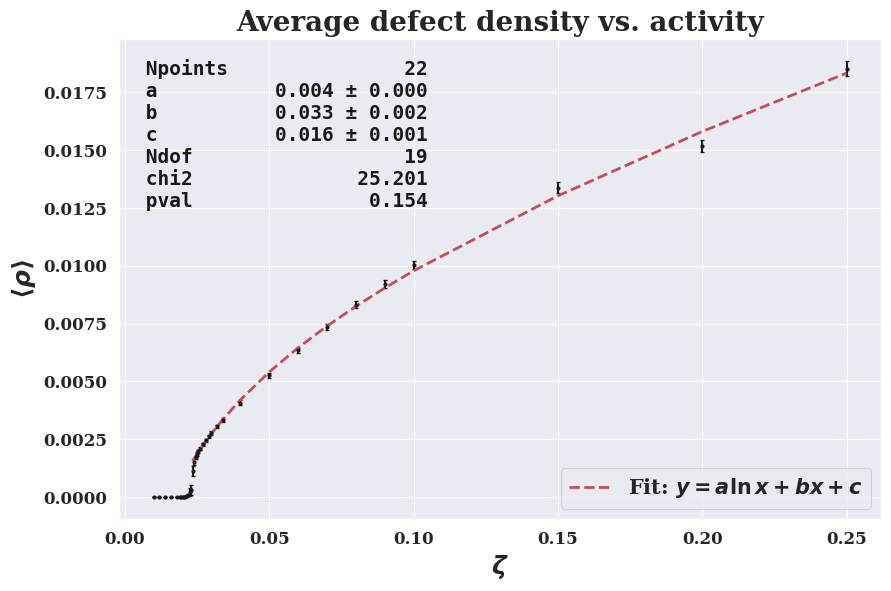

In [58]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.errorbar(act_list, av_defects_conv[:, 0], yerr = av_defects_conv[:, 1], fmt = 'k.', elinewidth=1.5, capsize=1.5, capthick=1, markersize = 4)
ax.set_xlabel(r'$\zeta$')
ax.set_ylabel(r'$\langle \rho \rangle$')
ax.set_title('Average defect density vs. activity')

ax.plot(act_list[lower_act_index:], fit_func(np.array(act_list[lower_act_index:]), *lin_fit.values[:]), 'r--', label=rf'Fit: {fit_string}')

d = {'Fit1: y = a1x + b1': '', 'a1': [lin_fit.values['a'], lin_fit.errors['a']], 'b1': [lin_fit.values['b'],lin_fit.errors['b'] ],\
      'Fit1 Ndof1': Ndof, 'chi2val1': chi2, 'pval1': pval}

d = generate_dictionary(lin_fit, len(act_list[lower_act_index:]), chi2_suffix = None)

#d.update(d_lower)
text = nice_string_output(d, extra_spacing=4, decimals=3)
add_text_to_ax(0.02, 0.96, text, ax, fontsize=14)
ax.legend(loc='lower right')

fig.tight_layout()
plt.show()

In [ ]:

rel_error = var_counts_std[:,min_window_idx:,:] / var_counts_av[:,min_window_idx:,:]
rel_error_av = np.nanmean(rel_error, axis=0)

rel_error_std = np.nanstd(rel_error, axis=0, ddof=1) / Nframes_non_nan_counts[np.newaxis, :]

fig, ax = plt.subplots(figsize=(9,6))
for i, act in enumerate(act_list):
    ax.errorbar(window_sizes[min_window_idx:], rel_error_av[:,i], rel_error_std[:,i], fmt='.', label = f'Act = {act}',\
                        capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 0.5, markersize=4)
    
ax.set_xlabel('Window size (1/sys. size)')
ax.set_ylabel('Rel. error in count variance')
fig.suptitle('Rel. error in count variance vs window size')
#ax.legend(loc='upper right')

xticks = np.array([1, 2.5, 5, 7.5, 10]) * 2.56
ax.set_xticks(xticks, labels = np.round(xticks / 256,3))
fig.legend(ncol=2, fontsize = 12, bbox_to_anchor=(0.99, 0.92))
fig.tight_layout()

In [162]:
def lin_func(x, alpha, beta):
    return beta * (2 - alpha) + (2 - alpha) * x
def power_func(x, b): #, c, d, e):
    return  b * x ** 2
def power_log_func(x, b): #, c, d, e):
    return  b * x ** 2 * np.log(x)

param_guess_lin = np.array([0.1, 0.3])
param_guess_power = np.array([2400])
param_guess_power_log = np.array([2000])

R = window_sizes[min_window_idx:]

fit_func = lin_func
param_guess = param_guess_lin
log_fit = True
fit_string = rf'$y = \beta(2-\alpha) + (2-\alpha)x$'
save_suffix = 'lin'


# Initial arrays to store the fit parameters and errors for all activities and frames
Nparams = len(param_guess)
fit_params = np.zeros([Nframes, len(act_list), 2 * Nparams]) * np.nan
stat_arr = np.zeros([Nframes, len(act_list), 3]) * np.nan

In [135]:
act_list[min_act_idx]

0.0195

In [147]:
for i,act in enumerate(act_list):
    if act < act_list[min_act_idx]:
        continue
    for frame in np.arange(first_frame_list[i], Nframes):
        count_var_av = var_counts_av[frame, min_window_idx:, i]
        count_var_std = var_counts_std[frame, min_window_idx:, i]
    if np.isnan(count_var_av).sum() > 0:
            continue
    zero_mask = count_var_av > 0
    count_var_av = count_var_av[zero_mask]
    count_var_std = count_var_std[zero_mask]
    
    if 0 < len(count_var_av) < 30:
        print("Fitting for activity {} and frame {}".format(act, frame))
        print(len(count_var_av))
        print(count_var_av)

Fitting for activity 0.02 and frame 180
5
[0.33333 0.33333 0.33333 0.33333 0.33333]
Fitting for activity 0.0205 and frame 180
8
[0.06667 0.06667 0.06667 0.06667 0.06667 0.06667 0.06667 0.23333]
Fitting for activity 0.0215 and frame 180
16
[0.01515 0.0303  0.0303  0.0303  0.0303  0.0603  0.06939 0.06939 0.06939
 0.08884 0.13956 0.19358 0.27197 0.25613 0.49222 0.53839]
Fitting for activity 0.022 and frame 180
27
[0.01636 0.01636 0.01636 0.01636 0.01636 0.01636 0.01636 0.01636 0.01636
 0.01636 0.03255 0.04771 0.04771 0.08522 0.11189 0.13643 0.15786 0.19648
 0.22743 0.27877 0.2928  0.41652 0.4259  0.54744 0.84391 1.14039 1.34937]


In [163]:
for i, act in enumerate(act_list):  
    if act < act_list[min_act_idx]:
        continue
    for frame in np.arange(first_frame_list[i], Nframes):
        count_var_av = var_counts_av[frame, min_window_idx:, i]
        count_var_std = var_counts_std[frame, min_window_idx:, i]
        if np.isnan(count_var_av).sum() > 0 or np.isnan(count_var_std).sum() > 0:
            continue

        zero_mask = count_var_av > 0
        if len(count_var_av[zero_mask]) < 10:
            continue

        if log_fit:
            try:
              #  with warnings.catch_warnings():
               #     warnings.simplefilter("ignore", category=np.runtimewarning)
                x = np.log(R[zero_mask])
                y = np.log(count_var_av[zero_mask])
                yerr = count_var_std[zero_mask] / count_var_av[zero_mask]
            except:
                print("Error in log for activity = ", act)
                continue
        else:
            x = R[zero_mask]
            y = count_var_av[zero_mask]
            yerr = count_var_std[zero_mask]

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=np.VisibleDeprecationWarning)
            fit = do_chi2_fit(fit_func, x, y, yerr, param_guess, verbose = False)

        Ndof, chi2, prop = get_statistics_from_fit(fit, len(R[zero_mask]), subtract_1dof_for_binning = False)
 
        fit_params[frame, i, :Nparams] = fit.values[:]
        fit_params[frame, i, Nparams:] = fit.errors[:]
        stat_arr[frame, i, :] = Ndof, chi2, prop

print("Non-converged fits: ", np.nansum((stat_arr[:, :, -1] < 0.05)))

# save
np.save(os.path.join(save_path, f'fit_params_{save_suffix}_normalize{normalize}.npy'), fit_params)
np.save(os.path.join(save_path, f'stat_arr_{save_suffix}_normalize{normalize}.npy'), stat_arr)

Non-converged fits:  5


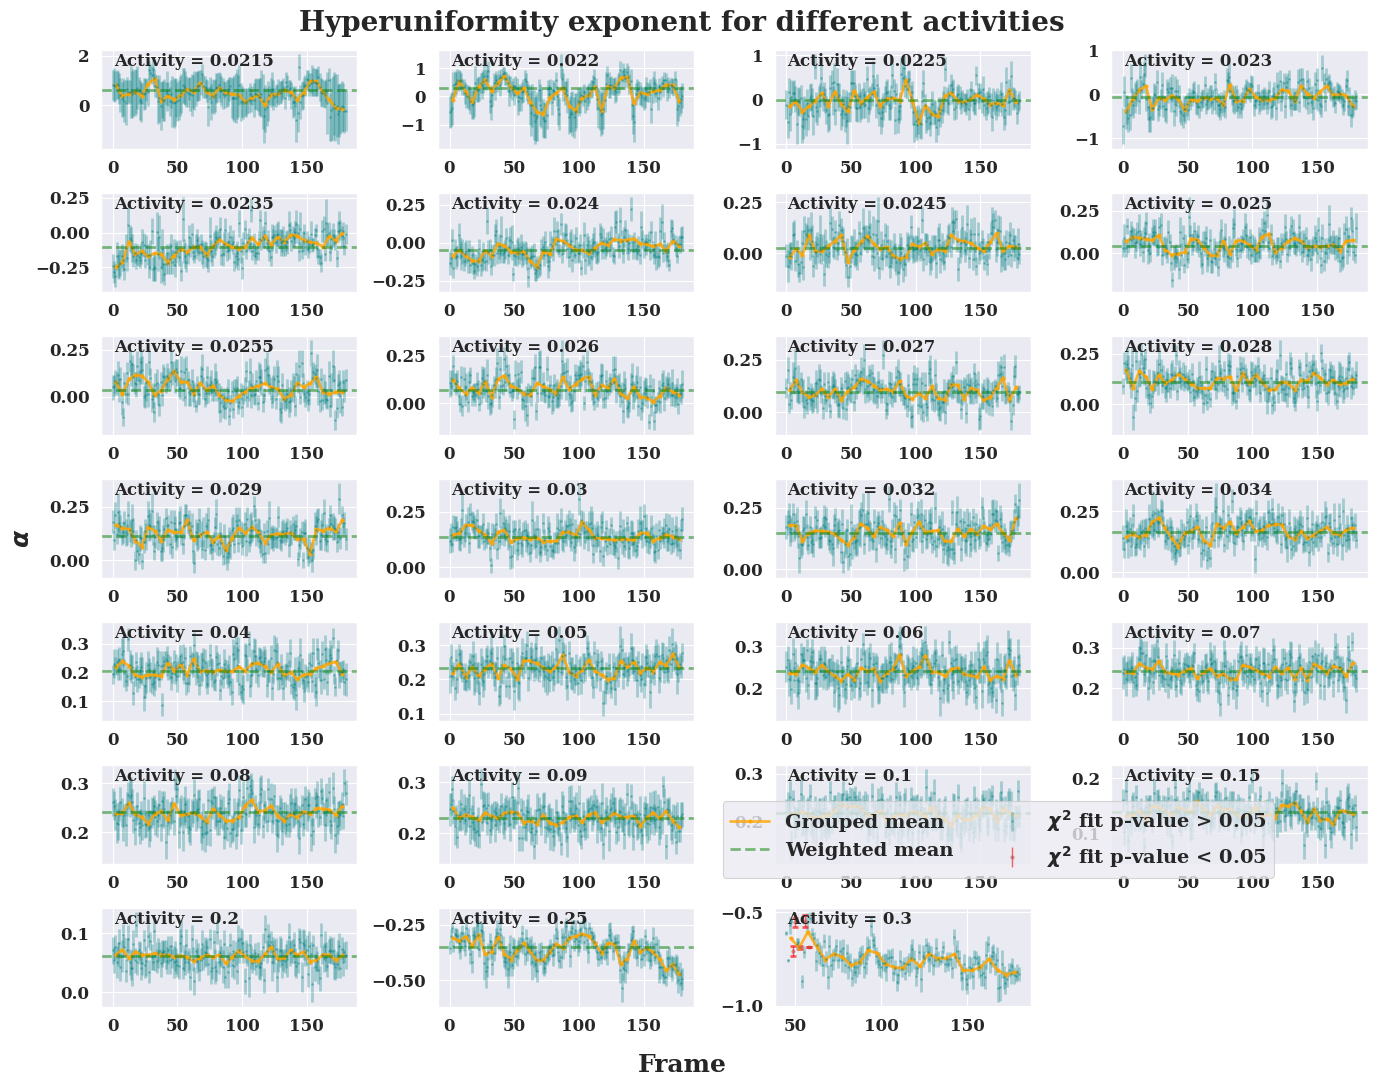

In [165]:
fig, ax = plt.subplots(nrows = 7, ncols = 4, figsize=(14, 11))

ax = ax.flatten()
Ngroup = 5

for i, act in enumerate(act_list[min_act_idx:]):
    act_idx = act_list.index(act)
    
    if i == 0:
        label1 = rf'$\chi^2$ fit p-value > 0.05'
        label2 = rf'$\chi^2$ fit p-value < 0.05'
        label3 = 'Weighted mean'
        label4 = 'Grouped mean'
    else:
        label1 = None
        label2 = None
        label3 = None
        label4 = None

    p_mask = stat_arr[first_frame_list[act_idx]:, act_idx, 2] > 0.05

    ax[i].errorbar(np.arange(first_frame_list[act_idx], Nframes)[p_mask], \
                   fit_params[first_frame_list[act_idx]:,act_idx,0][p_mask], \
                    fit_params[first_frame_list[act_idx]:,act_idx,Nparams][p_mask], \
                       fmt='.', \
                   alpha = 0.3, markersize=2, label = label1)# ecolor='black')capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, 
    
    ax[i].errorbar(np.arange(first_frame_list[act_idx], Nframes)[~p_mask], \
                     fit_params[first_frame_list[act_idx]:,act_idx,0][~p_mask], \
                      fit_params[first_frame_list[act_idx]:,act_idx,Nparams][~p_mask], \
                        fmt='r.', \
                     capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 0.6, markersize=2, ecolor='red', label = label2)

    x = fit_params[first_frame_list[act_idx]:, act_idx, 0]

    max_idx = len(x) - len(x) % Ngroup 
    # group the data and calculate the weighted mean and error on mean
    x_group = x[:max_idx].reshape(-1, Ngroup).mean(axis=1)
    dx_group = np.std(x[:max_idx].reshape(-1, Ngroup), axis=1, ddof=min(Ngroup-2, 1)) / np.sqrt(Ngroup)
    x_frames = np.arange(first_frame_list[act_idx], first_frame_list[act_idx] + max_idx, Ngroup) + Ngroup / 2

    # plot x_group and dx_group
    ax[i].plot(x_frames, x_group, '.-', color='orange', alpha=0.8, markersize=4, label = label4)
    if 0:
        ax[i].errorbar(x_frames, \
                    x_group, \
                        dx_group, \
                        fmt='.', \
                    alpha = 0.5, markersize=4, ecolor='orange')


    mean, err, Ndof, chi2, p_val = calc_weighted_mean_vec(x_group, dx_group)
    #ax[i].axhline(mean, color='orange', linestyle='-', alpha=0.5, lw = 2, label = label3)
    

    # calc and plot weighted mean and error on mean for all frames and activities
    mean, err, Ndof, chi2, p_val = calc_weighted_mean_vec(x, fit_params[first_frame_list[i]:, act_idx, Nparams])
    ax[i].axhline(mean, color='green', linestyle='--', alpha=0.5, lw = 2, label = label3)
    
    # plot vertical lines to indicate the start of the averaging
  #  ax[i].axhline(0, color='black', linestyle='--', alpha=0.5)
    #ax[i].set_ylim(np.min(defect_arr_av[:,i])/2, np.max(defect_arr_av[:, i]) + 2  * np.max(defect_arr_std[:, i]))
    ax[i].text(0.05, 0.97, 'Activity = {}'.format(act), transform=ax[i].transAxes, fontsize=12, verticalalignment='top')
    if 0:
        if i < 3:
            ax[i].text(0.05, 0.9, 'Activity = {}'.format(act), transform=ax[i].transAxes, fontsize=14, verticalalignment='top')
        else:
            ax[i].text(0.4, 0.1, 'Activity = {}'.format(act), transform=ax[i].transAxes, fontsize=14, verticalalignment='bottom')

#ax[-2].axis('off')
ax[-1].axis('off')

fig.suptitle('Hyperuniformity exponent for different activities')
fig.supxlabel('Frame')
fig.supylabel(rf'$\alpha$')
fig.legend(ncol=2, fontsize = 14,bbox_to_anchor=(0.93, 0.27))

plt.tight_layout()
plt.show()

In [12]:
def lin_func_dens(x, alpha, beta):
    return beta * (- 2 - alpha) + (- 2 - alpha) * x
def power_func(x, b): #, c, d, e):
    return  b * x ** 2
def power_log_func(x, b): #, c, d, e):
    return  b * x ** 2 * np.log(x)

param_guess_lin_dens = np.array([0.1, 0.1])
param_guess_power = np.array([2400])
param_guess_power_log = np.array([2000])

R = window_sizes[min_window_idx:]

fit_func = lin_func_dens
param_guess = param_guess_lin_dens
log_fit = True
fit_string = rf'$y = -\beta(2+\alpha) - (2+\alpha)x$'
save_suffix = 'lin'


# Initial arrays to store the fit parameters and errors for all activities and frames
Nparams = len(param_guess)
fit_params_time_av = np.zeros([len(act_list), 2 * Nparams]) * np.nan
stat_arr_time_av = np.zeros([len(act_list), 3]) * np.nan




c:\Users\Simon Andersen\miniconda3\envs\sf\lib\site-packages\matplotlib\axes\_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


[     nan      nan      nan      nan      nan      nan      nan      nan
      nan      nan      nan      nan  0.16967  0.13843 -0.06929 -0.02738
  0.03489  0.05699  0.05316  0.0795   0.10532  0.1181   0.12572  0.14466
  0.1551   0.1691   0.21185  0.23373  0.2411   0.24252  0.23862  0.23066
  0.21501  0.13806  0.06085 -0.36128  0.1    ]
[    nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan 0.0512  0.98435 0.      0.      0.00011 0.00131
 0.00007 0.00093 0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
     nan]


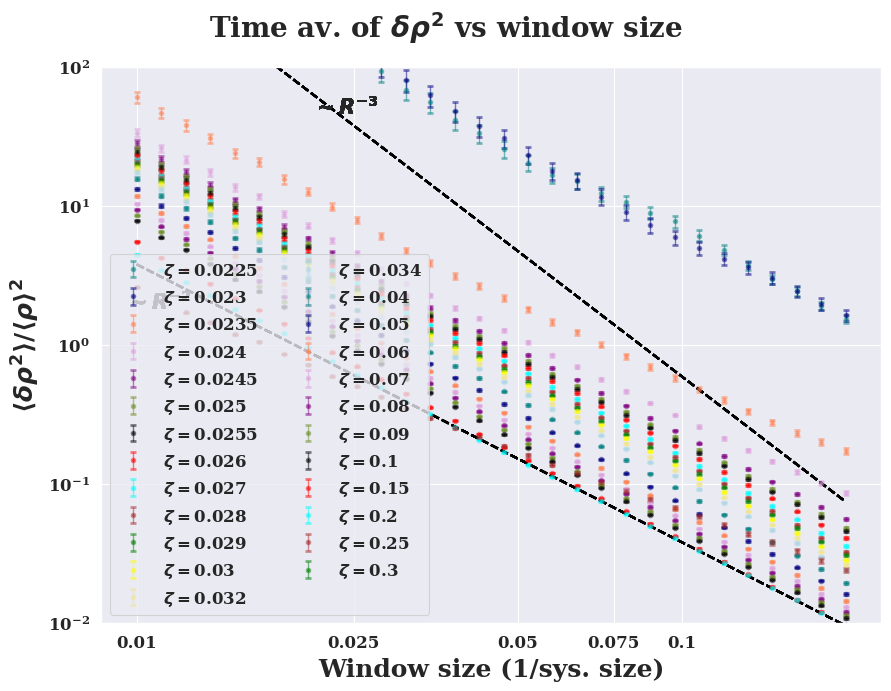

In [13]:

fig, ax = plt.subplots(figsize=(9,7))
for i, act in enumerate(act_list):
    if act < 0.0225:
        continue

    frames_av_dens = np.mean(dens_fluc_av[first_frame_list[i]:, min_window_idx:,i], axis = 0)
    frames_av_dens_std = np.mean(dens_fluc_std[first_frame_list[i]:, min_window_idx:,i], axis = 0) \
                      / np.sqrt(Nframes_non_nan_counts[i])

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=np.VisibleDeprecationWarning)
        fit = do_chi2_fit(fit_func, np.log(R), np.log(frames_av_dens), frames_av_dens_std / frames_av_dens, param_guess, verbose = False)

    Ndof, chi2, prop = get_statistics_from_fit(fit, len(R), subtract_1dof_for_binning = False)

    fit_params_time_av[i, :Nparams] = fit.values[:]
    fit_params_time_av[i, Nparams:] = fit.errors[:]
    stat_arr_time_av[i, :] = Ndof, chi2, prop


    ax.errorbar(window_sizes[min_window_idx:], frames_av_dens, \
                frames_av_dens_std, fmt='.', label = fr'$\zeta = ${act}',\
                        capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 0.5, markersize=4)

    ax.plot(window_sizes[min_window_idx:], 25 / window_sizes[min_window_idx:] ** (2), '--', color='black', alpha=0.5, lw = 1.5)
    ax.text(0.03, 0.6, r'$\sim R^{-2}$', fontsize=15, transform=ax.transAxes, verticalalignment='top', fontweight='normal')

    ax.plot(window_sizes[min_window_idx:], 10000/ window_sizes[min_window_idx:] ** (3), '--', color='black', alpha=0.5, lw = 1.5)
    ax.text(0.27, 0.95, r'$\sim R^{-3}$', transform=ax.transAxes, fontsize=15, verticalalignment='top', fontweight='normal')

ax.set_xlabel('Window size (1/sys. size)')
ax.set_ylabel(rf'$\langle \delta \rho ^2 \rangle /  \langle \rho \rangle ^2$')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(bottom=0.01, top = 100)
xticks = np.array([1, 2.5, 5, 7.5, 10]) * 2.56
ax.set_xticks(xticks, labels = np.round(xticks / 256,3))
ax.legend(ncol=2, fontsize = 12, loc = 'lower left') 

fig.suptitle(rf'Time av. of $ \delta \rho^2$ vs window size')
fig.tight_layout()

print(fit_params_time_av[:,0])
print(stat_arr_time_av[:,-1])

np.save(os.path.join(save_path, f'fit_params_{save_suffix}_normalize{normalize}_time_av.npy'), fit_params_time_av)
np.save(os.path.join(save_path, f'stat_arr_{save_suffix}_normalize{normalize}_time_av.npy'), stat_arr_time_av)

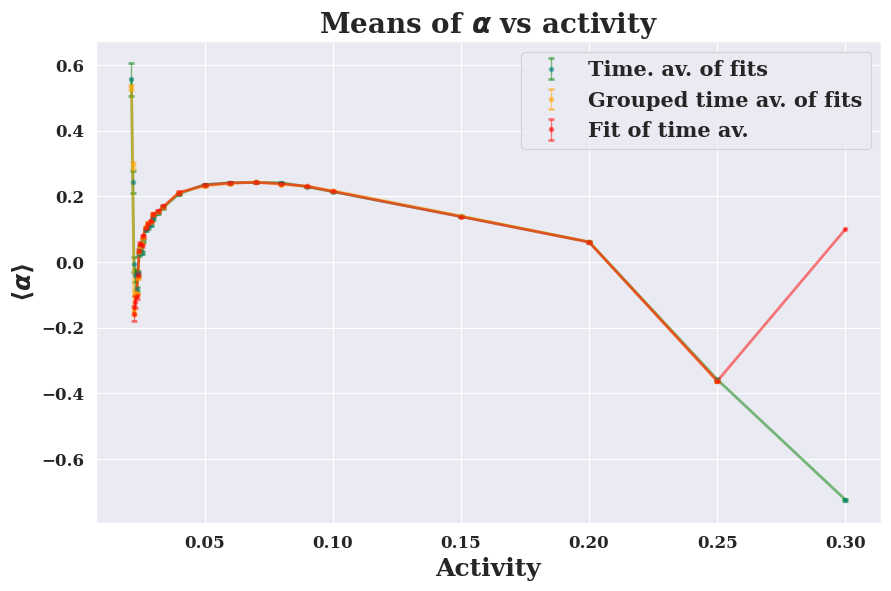

In [168]:
# calc weighted mean and error on mean for all frames and activities

Ngroup = 5
group = True
weighted_means_list = []
weighted_errs_list = []
weighted_means_group_list = []
weighted_errs_group_list = []

for i, act in enumerate(act_list):
        if act < act_list[min_act_idx]:
               continue
        
        if group:
                x = fit_params[first_frame_list[i]:, i, 0]

                max_idx = len(x) - len(x) % Ngroup
                # group the data and calculate the weighted mean and error on mean
                x_group = x[:max_idx].reshape(-1, Ngroup).mean(axis=1)
                dx_group = np.std(x[:max_idx].reshape(-1, Ngroup), axis=1, ddof=min(Ngroup-2, 1)) / np.sqrt(Ngroup)

                mean, err, Ndof, chi2, p_val = calc_weighted_mean_vec(x_group, dx_group)
                weighted_means_group_list.append(mean)
                weighted_errs_group_list.append(err)
      
        if 1:
             #   p_mask = (0.05 < stat_arr[first_frame_list[i]:, i, 2])  
                x = fit_params[first_frame_list[i]:, i, 0][p_mask]
                dx = fit_params[first_frame_list[i]:, i, Nparams][p_mask]

        try:
                mean, err, Ndof, chi2, p_val = calc_weighted_mean_vec(x, dx)
                weighted_means_list.append(mean)
                weighted_errs_list.append(err)
        except:
                print("No fits for activity = {}".format(act))
                weighted_means_list.append(np.nan)
                weighted_errs_list.append(np.nan)


fig2, ax2 = plt.subplots(figsize=(9,6))
ax2.errorbar(act_list[min_act_idx:], weighted_means_list, weighted_errs_list, fmt='.', label = 'Time. av. of fits', \
             capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 0.5, markersize=4, ecolor='green')
ax2.plot(act_list[min_act_idx:], weighted_means_list, '-', color='green', alpha=0.5, )
ax2.errorbar(act_list[min_act_idx:], weighted_means_group_list, weighted_errs_group_list, fmt='.', label = 'Grouped time av. of fits', \
             capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 0.5, markersize=4, ecolor='orange', color = 'orange')
ax2.plot(act_list[min_act_idx:],weighted_means_group_list,  '-',color='orange', alpha=0.5)
ax2.errorbar(act_list[min_act_idx:], fit_params_time_av[min_act_idx:,0], fit_params_time_av[min_act_idx:,Nparams], fmt='.', label = 'Fit of time av.', \
             capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 0.5, markersize=4, ecolor='red', color = 'red'
             )
ax2.plot(act_list[min_act_idx:], fit_params_time_av[min_act_idx:,0], '-', color='red', alpha=0.5)

ax2.set_xlabel('Activity')
ax2.set_ylabel(rf'$\langle\alpha \rangle$')
ax2.set_title(rf'Means of $\alpha $ vs activity')
ax2.legend()
fig2.tight_layout()

In [180]:
act_list[6]

0.0195

In [222]:
min_window_cutoff_idx

5

In [230]:
cutoff = 6
for j, windows in enumerate(window_sizes):
    norm = 1 # xi_av[j, act_max_idx]
    
    print("\nWindow size: ", windows)
    print(xi_av[j, cutoff:]/ norm)
    print(act_list[cutoff + np.argmax(xi_av[j,cutoff:] / norm)])


Window size:  2.56
[5257.78139    0.      4387.05777 2648.6197  2068.08902 1778.46899
 1623.87862  976.80433   61.15798   33.77452   28.40282   25.95518
   24.69697   22.93319   21.48396   20.85377   20.15735   19.33025
   18.48314   17.59665   15.77616   13.39077   11.82303   10.46587
    9.43678    8.59757    7.85814    5.56473    4.4959     2.6255
    1.96947]
0.0195

Window size:  2.8385926153622494
[5103.05416    0.      2902.15725 1752.13349 1556.2496  1318.87468
 1145.15328  787.2353    46.8471    26.15063   21.86258   19.97538
   19.10111   17.66763   16.49763   15.97773   15.47632   14.75215
   14.0417    13.37578   11.95192   10.13407    8.97071    7.96421
    7.19702    6.5643     5.99818    4.27779    3.48406    2.09121
    1.60256]
0.0195

Window size:  3.14750313905824
[3375.8082     0.      2452.71684 2368.82305 1291.72996 1043.41723
  843.82689  642.17262   38.33011   21.69076   17.72      16.25717
   15.51609   14.37769   13.40082   12.89712   12.59648   12.00121
   1

In [226]:
act_list[act_max_idx]

0.021

In [196]:
dens_fluc2.shape

(181, 30, 37, 10)

C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_2648\4186391345.py:7: RuntimeWarning: Mean of empty slice
  dens_fluc_av2 = np.nanmean(dens_fluc2, axis=3)
C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_2648\4186391345.py:17: RuntimeWarning: Mean of empty slice
  xi_av =  np.nanmean(dens_fluc_av2, axis = 0) #* window_sizes[:, None]**2  #** 2


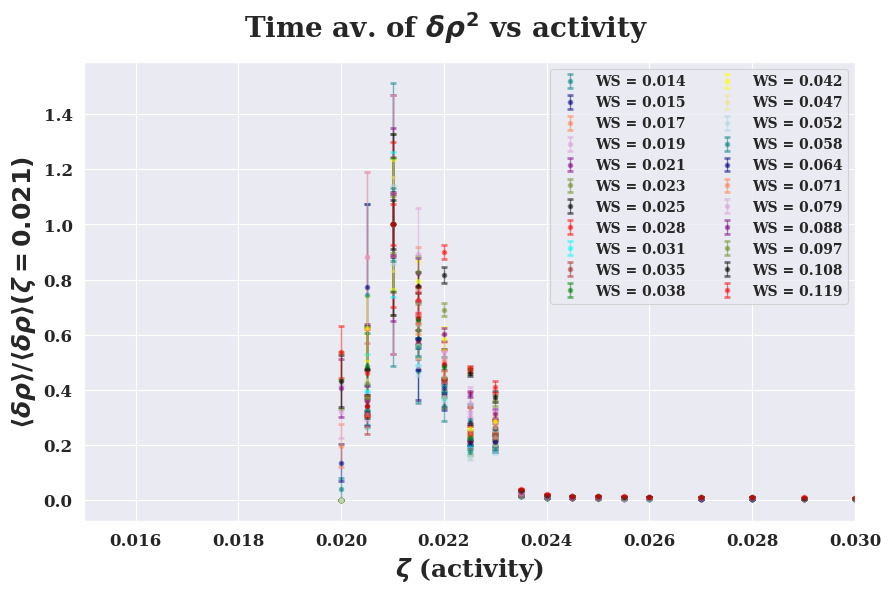

In [224]:
dens_fluc2 = np.load(os.path.join(save_path, 'dens_fluc.npy'))[:, :, :, idx_exp_to_keep_list][:, :, idx_act_to_keep_list, :]
dens_fluc2 = dens_fluc2 * exp_conv_list.T[np.newaxis, np.newaxis, :Nactivity, :]

av_dens_arr = defect_arr
dens_fluc2 = dens_fluc2 / av_dens_arr[:, None, :, :] ** 2

dens_fluc_av2 = np.nanmean(dens_fluc2, axis=3)
dens_fluc_std2 = np.nanstd(dens_fluc2, axis=3, ddof=1) / (np.sqrt(np.nanmean(exp_conv_list, axis=0))[:Nactivity])[None, None, :]

if 0:
    av_density_all_windows2 = av_defects_conv[:, 0] 
    dens_fluc_av2 = dens_fluc_av2 / av_density_all_windows2[:, None, :] ** 2
    dens_fluc_std2 = dens_fluc_std2 / av_density_all_windows2[:, None, :] ** 2

logplot = False

xi_av =  np.nanmean(dens_fluc_av2, axis = 0) #* window_sizes[:, None]**2  #** 2
xi_std = np.nanstd(dens_fluc_av2, axis = 0, ddof=1) / np.sqrt(Nframes_non_nan_counts[np.newaxis, :]) #* window_sizes[:, None]**2 #** 2

fig, ax = plt.subplots(figsize=(9,6))

min_act_cutoff_idx = 7
min_window_cutoff_idx = 3
max_window_cutoff_idx = -5
act_max_idx = act_list.index(0.021)

for j, window in enumerate(window_sizes[min_window_cutoff_idx:]):
        if window >= window_sizes[max_window_cutoff_idx]:
             continue
        norm = xi_av[j + min_window_cutoff_idx, act_max_idx]
        if j % 1 == 0: #in [1,2,3,4,5,6,7]:
            ax.errorbar(act_list[min_act_cutoff_idx:], xi_av[j + min_window_cutoff_idx, min_act_cutoff_idx:] / norm,\
                            xi_std[j + min_window_cutoff_idx, min_act_cutoff_idx:] / norm, label=f'WS = {np.round(window / 256,3)}', fmt='.', \
                   capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 0.5, markersize=4)

ax.set_xlabel(rf'$\zeta$ (activity)')
ax.set_ylabel(rf'$\langle \delta \rho \rangle / \langle \delta \rho \rangle (\zeta = {act_list[act_max_idx]}) $')
ax.set_xlim(0.015,0.03)

if logplot:
  #  ax.set_yscale('log')
    ax.set_xscale('log')

#add legend above the plot in 3 rows
ax.legend(loc='upper right', ncol=2, fontsize = 10,)
fig.suptitle(rf'Time av. of $\delta \rho ^2$ vs activity', fontsize=20)
fig.tight_layout()
plt.show()

C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_2648\345145293.py:5: RuntimeWarning: Mean of empty slice
  binder_cumulants = 1 - np.nanmean(np.nanmean((av_counts/(np.pi * window_sizes[None,:,None,None]**2)) ** 4, axis = -1), axis = 0) \
C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_2648\345145293.py:6: RuntimeWarning: Mean of empty slice
  / (3 * np.nanmean(np.nanmean((av_counts/(np.pi * window_sizes[None,:,None,None]**2)) ** 2, axis = -1), axis = 0) ** 2)
C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_2648\345145293.py:5: RuntimeWarning: invalid value encountered in true_divide
  binder_cumulants = 1 - np.nanmean(np.nanmean((av_counts/(np.pi * window_sizes[None,:,None,None]**2)) ** 4, axis = -1), axis = 0) \


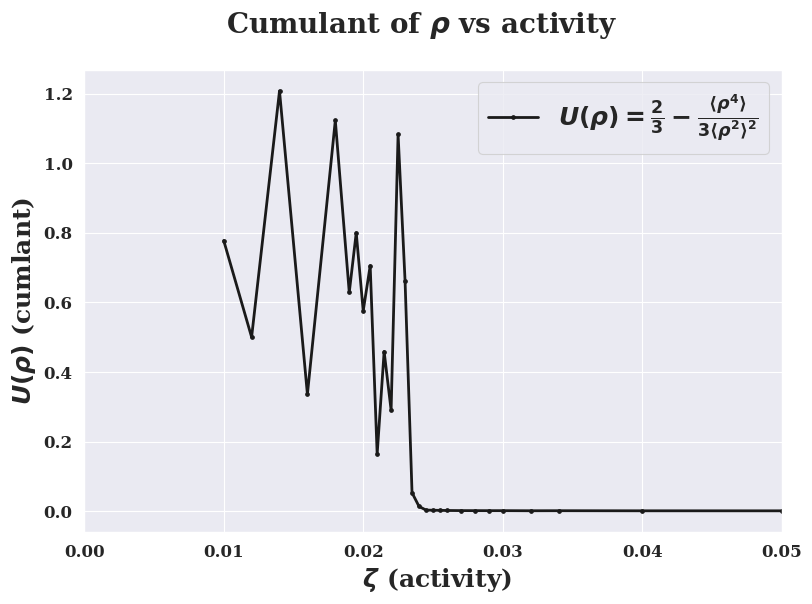

In [189]:
binder_tot = 1 - np.nanmean(np.nanmean(defect_arr[:,:,:] ** 4, axis = -1), axis = 0) \
  / (3 * np.nanmean(np.nanmean(defect_arr[:,:,:] ** 2, axis = -1), axis = 0) ** 2)


binder_cumulants = 1 - np.nanmean(np.nanmean((av_counts/(np.pi * window_sizes[None,:,None,None]**2)) ** 4, axis = -1), axis = 0) \
  / (3 * np.nanmean(np.nanmean((av_counts/(np.pi * window_sizes[None,:,None,None]**2)) ** 2, axis = -1), axis = 0) ** 2)

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(act_list, 2/3 - binder_tot, 'k.-', label=r'$U(\rho) = \frac{2}{3} - \frac{\langle \rho^4 \rangle}{3 \langle \rho^2 \rangle ^2}$')

ax.set_xlim(0, 0.05)
ax.set_xlabel(r' $\zeta$ (activity)')
ax.set_ylabel(r'$U(\rho)$ (cumlant)')
ax.legend(loc='upper right', ncol=2, fontsize = 18)
fig.suptitle(rf'Cumulant of $\rho$ vs activity', fontsize=20)

plt.show()